# ANALISA SAHAM PT ADHI KARYA (PERSERO) TBK (ADHI)

### DESKRIPSI PERUSAHAAN
Profil Perusahaan: PT Adhi Karya (Persero) Tbk
PT Adhi Karya (Persero) Tbk merupakan Badan Usaha Milik Negara (BUMN) yang berdiri sejak tahun 1960 dan secara resmi mengubah nama menjadi seperti sekarang pada tahun 1974. Berkantor pusat di Jakarta, perusahaan ini menjadi salah satu pelaku utama dalam industri konstruksi dan infrastruktur nasional.
Adhi Karya menjalankan kegiatan usahanya melalui empat segmen bisnis utama, yaitu Rekayasa dan Konstruksi, Properti dan Perhotelan, Manufaktur, Investasi dan Konsesi.

### OBJECTIVES DAN SUMBER DATA
Dengan menggunakan data dari berbagai sumber kita akan menganalisa saham ADHI baik secara analisa teknikal dan juga analisa fundamental. Pada analisa teknikal kita akan membandingkan hasil prediksi 1 minggu kedepan menggunakan 4 metode yakni dengan Machine Learning (menggunakan `RandomForestRegressor` dan `XGBoostRegressor`), Moving Average, Exponential Smoothing dan SARIMAX. Pada analisa fundamental kita akan memberikan review terhadap P/E dan P/BV ratio serta Ringkasan Cash Flow dan Balance Sheet perusahaan ini. Barulah setelah kita melakukan analisa teknikal dan fundamental, kita akan menentukan apakah saham ini direkomendasikan untuk dibeli atau tidak.

SUMBER DATA:
1. https://finance.yahoo.com/quote/ADHI.JK/history/ (Yahoo Finance)
2. https://finance.yahoo.com/quote/ADHI.JK/financials/ (Yahoo Finance)
3. https://finbox.com/IDX:ADHI/explorer/pe_ltm/ (finbox)
4. https://finbox.com/IDX:ADHI/explorer/price_to_book (finbox)

In [3]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options

In [103]:
# Path ke ChromeDriver
chrome_driver_path = "C:\Programming\.vscode\BootcampBatch9\chromedriver-win64\chromedriver.exe"

# Konfigurasi opsi Chrome
options = Options()
options.add_argument("--headless=new")  # Jalankan tanpa membuka jendela browser
options.add_argument("--disable-gpu")   # Mengurangi penggunaan GPU
options.add_argument("--no-sandbox")    # Untuk eksekusi di server tanpa GUI
options.add_argument("--disable-dev-shm-usage")  # Untuk menghindari error pada sistem berbasis Linux

# Inisialisasi WebDriver
service = Service(chrome_driver_path)
driver = webdriver.Chrome(service=service, options=options)

# Buka halaman Yahoo Finance
driver.get("https://finance.yahoo.com/quote/ADHI.JK/history/")

# Tunggu hingga tabel muncul
table = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CLASS_NAME, "table"))
)

# Ambil semua baris tabel
rows = table.find_elements(By.TAG_NAME, "tr")

data = []
for row in rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) == 7:
        date = cols[0].text 
        open = cols[1].text
        high = cols[2].text 
        low = cols[3].text  
        close = cols[4].text
        adj_close = cols[5].text  
        volume = cols[6].text  
        data.append([date, open, high, low, close, adj_close, volume])

# Simpan dalam DataFrame Pandas
df = pd.DataFrame(data, columns=["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"])

# Tutup browser
driver.quit()

<>:2: SyntaxWarning:

invalid escape sequence '\P'

<>:2: SyntaxWarning:

invalid escape sequence '\P'

C:\Users\anton\AppData\Local\Temp\ipykernel_29080\3765440207.py:2: SyntaxWarning:

invalid escape sequence '\P'



## CLOSE POINT ANALYSIS

Melakukan proyeksi/forecast terhadap 'CLOSE' point dari saham ADHI dengan menggunakan 4 metode: yakni dengan Machine Learning (menggunakan `RandomForestRegressor` dan `XGBoostRegressor`), Moving Average, Exponential Smoothing dan SARIMAX.

In [10]:
# df.to_csv('ADHI_stocks.csv', index=False)

In [4]:
df = pd.read_csv('ADHI_stocks.csv')

In [5]:
df[df.columns] = df[df.columns].astype(str)

### PERMODELAN DENGAN MACHINE LEARNING

In [6]:
# -------------------------
# 1. Preprocessing Data
# -------------------------
def preprocess_data(df_raw):
    df = df_raw.copy()
    df['Date'] = df['Date'].astype(str)
    df = df[df['Date'].str.match(r'^[A-Za-z]{3,} \d{1,2}, \d{4}$', na=False)]
    df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')

    cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
    for col in cols:
        df[col] = df[col].str.replace(',', '', regex=False).astype(float)

    df = df.sort_values('Date').reset_index(drop=True)
    return df

# -------------------------
# 1b. Tambahkan Indikator Teknikal
# -------------------------
def add_technical_indicators(df, target_col):
    df = df.copy()
    df['MA_5'] = df[target_col].rolling(window=5).mean()
    df['MA_10'] = df[target_col].rolling(window=10).mean()
    df['EMA_12'] = df[target_col].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df[target_col].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Momentum'] = df[target_col] - df[target_col].shift(1)
    df['Volatility_5'] = df[target_col].rolling(window=5).std()
    df['Price_Range'] = df['High'] - df['Low']

    delta = df[target_col].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    df.dropna(inplace=True)
    return df

# -------------------------
# 2. Outlier Removal (IQR)
# -------------------------
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# -------------------------
# 3. Buat Multivariat Lag Features
# -------------------------
def create_multivariate_lag_features(df, target_cols, feature_cols, window):
    lagged_features = []
    for col in feature_cols:
        for i in range(1, window + 1):
            lagged_features.append(df[col].shift(i).rename(f'{col}_lag_{i}'))

    df_lag = pd.concat(lagged_features, axis=1)
    target_data = df[target_cols].copy()
    df_lag = pd.concat([df_lag, target_data], axis=1)
    df_lag.dropna(inplace=True)
    return df_lag

# -------------------------
# 4. Grid Search Lag dengan TimeSeriesSplit
# -------------------------
def grid_search_best_lag(df, target_cols, feature_cols, regressor, test_size=7, window_options=[i + 1 for i in range(20)]):
    df = df.reset_index(drop=True)
    df_train = df[:-test_size]
    df_test = df[-test_size:]

    results = []
    for window in window_options:
        df_ml = create_multivariate_lag_features(df_train, target_cols, feature_cols, window)
        if df_ml.shape[0] == 0:
            continue

        X = df_ml.drop(columns=target_cols)
        y = df_ml[target_cols]

        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_scaled = scaler_x.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y)

        tscv = TimeSeriesSplit(n_splits=5)
        val_rmses = []

        for train_index, val_index in tscv.split(X_scaled):
            x_train, x_val = X_scaled[train_index], X_scaled[val_index]
            y_train, y_val = y_scaled[train_index], y_scaled[val_index]
            model = MultiOutputRegressor(regressor)
            model.fit(x_train, y_train)
            y_pred_val = model.predict(x_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
            val_rmses.append(rmse)

        avg_rmse = np.mean(val_rmses)
        results.append((window, avg_rmse))

    return results

# -------------------------
# 5. Plot RMSE per Window
# -------------------------
def plot_grid_results(results):
    windows, rmses = zip(*results)
    plt.figure(figsize=(10, 5))
    plt.plot(windows, rmses, marker='o')
    plt.title("Evaluasi Jumlah Lag berdasarkan TimeSeries RMSE")
    plt.xlabel("Jumlah Lag (window)")
    plt.ylabel("RMSE rata-rata")
    plt.xticks(windows)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------
# 6. Forecast Future Function
# -------------------------
def forecast_future(model, df, scaler_x, scaler_y, target_cols, feature_cols, window, n_future):
    last_df = df[feature_cols].iloc[-window:].copy()
    forecast_scaled = []

    for _ in range(n_future):
        lag_data = {}
        for col in feature_cols:
            for i in range(1, window + 1):
                lag_data[f'{col}_lag_{i}'] = last_df[col].iloc[-i]

        input_df = pd.DataFrame([lag_data])
        input_scaled = scaler_x.transform(input_df)
        pred_scaled = model.predict(input_scaled)[0]
        pred_unscaled = scaler_y.inverse_transform([pred_scaled])[0]
        forecast_scaled.append(pred_unscaled)

        next_row = dict(zip(target_cols, pred_unscaled))
        last_df = pd.concat([last_df, pd.DataFrame([next_row])], ignore_index=True)

    return np.array(forecast_scaled)

# -------------------------
# 7. Visualize Forecast Function
# -------------------------

def visualize_forecast(df_clean, forecast, target_col, n_future=7, last_n_days=3):
    # Ambil n hari terakhir dari data historis
    last_n_dates = df_clean['Date'].iloc[-last_n_days:].tolist()
    last_n_close = df_clean[target_col].iloc[-last_n_days:].tolist()

    # Ambil tanggal terakhir dari data
    last_date = df_clean['Date'].iloc[-1]

    # Buat tanggal untuk masa depan
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

    # Gabungkan titik akhir histori dengan hasil prediksi
    forecast_dates_full = [last_n_dates[-1]] + future_dates
    forecast_values_full = [last_n_close[-1]] + forecast[:, 0].tolist()

    # Gabungkan semua tanggal untuk sumbu x
    all_dates = last_n_dates + future_dates

    # --- Visualisasi ---
    plt.figure(figsize=(10, 5))
    plt.plot(last_n_dates, last_n_close, label=f'Actual (Last {last_n_days} Days)', linestyle='-', marker='o')
    plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

    # Skala y
    all_y_values = last_n_close + forecast_values_full[1:]
    y_max = max(all_y_values)
    y_min = min(all_y_values)
    plt.ylim(y_min * 0.98, y_max * 1.05)

    # Label angka
    for date, value in zip(last_n_dates, last_n_close):
        plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
    for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
        plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

    plt.title(f'Price Forecasting: Last {last_n_days} Days + Next {n_future} Days')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.xticks(ticks=all_dates, rotation=45)
    plt.tight_layout()
    plt.show()

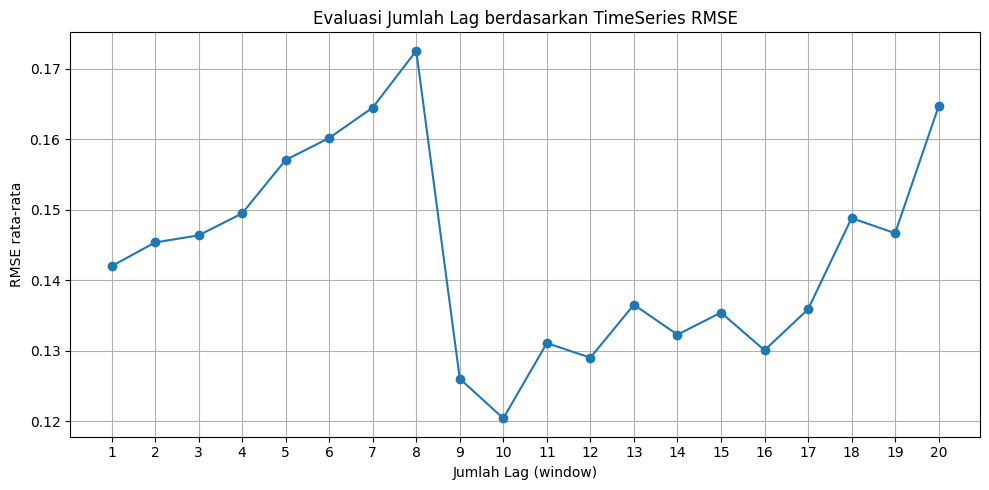

In [7]:
tgt = 'Close'
 
df_clean = preprocess_data(df)
df_clean = add_technical_indicators(df_clean, tgt)
df_clean = remove_outliers_iqr(df_clean, tgt)

# target & fitur
target_columns = [tgt]
feature_columns = ['Open', 'High', 'Low','MA_5', 'MA_10', 'EMA_12', 'EMA_26', 'MACD', 'Momentum', 'Volatility_5', 'Price_Range', 'RSI']

# Cari window terbaik
results_rf = grid_search_best_lag(df_clean, target_columns, feature_columns, RandomForestRegressor(n_estimators=100, random_state=42), )
plot_grid_results(results_rf)
best_window = min(results_rf, key=lambda x: x[1])[0]
rf_rmse = min(results_rf, key=lambda x: x[1])[1]

c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:31:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:31:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:31:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:31:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are

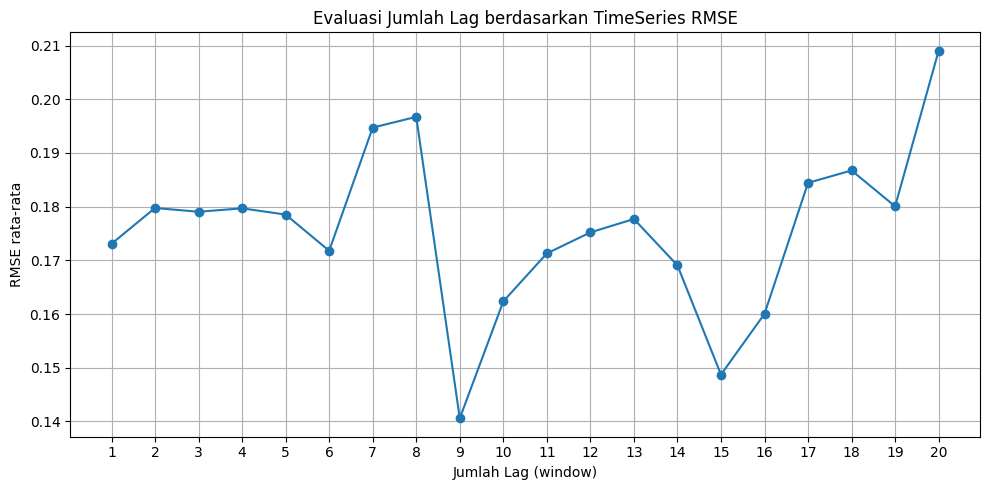

In [8]:
results_xgb = grid_search_best_lag(df_clean, target_columns, feature_columns, XGBRegressor(n_estimators=100, dart_normalized_type='forest'), )
plot_grid_results(results_xgb)
best_window_xgb = min(results_xgb, key=lambda x: x[1])[0]
xgb_rmse = min(results_xgb, key=lambda x: x[1])[1]

#### PREDIKSI DENGAN RANDOM FOREST

In [9]:
# Data untuk training
df_ml = create_multivariate_lag_features(df_clean, target_columns, feature_columns, best_window)
x = df_ml.drop(columns=target_columns)
y = df_ml[target_columns]

In [10]:
# Normalisasi
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [11]:
# Train model multi-target
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(x_scaled, y_scaled)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

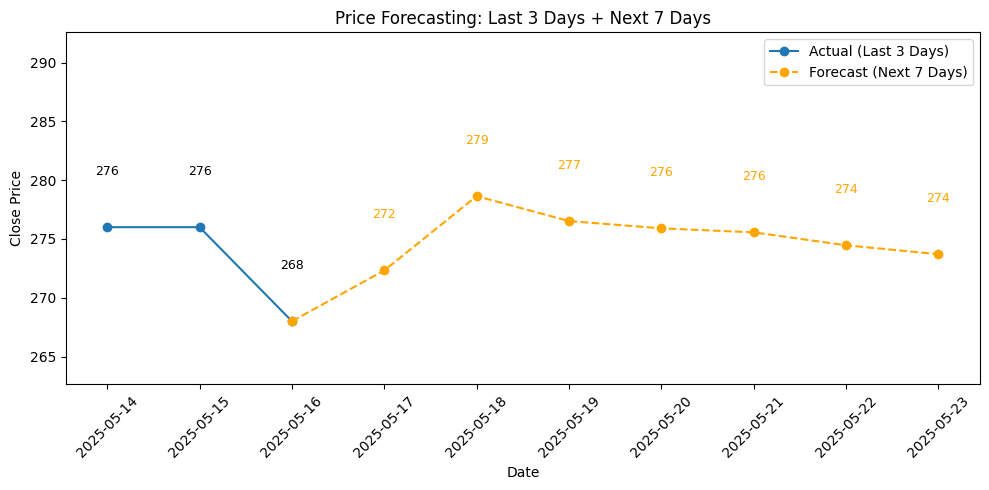

In [12]:
# Forecast
forecast = forecast_future(model, df_clean, scaler_x, scaler_y, target_columns, feature_columns, best_window, n_future=7)

# Visualisasi prediksi 'Close'
visualize_forecast(df_clean, forecast, tgt, n_future=7, last_n_days=3)

In [13]:
# Evaluasi di Data data training

from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Prediksi terhadap data training (rekonstruksi)
y_pred = model.predict(x_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_scaled)

# Evaluasi semua target
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_true_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_true_inv[:, i], y_pred_inv[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")


Close - MAPE: 1.07%, R²: 0.990


In [14]:
# Evaluasi di Data Test (7 Hari Terakhir)

df_test = df_clean[-(best_window + 7):]  # ambil untuk lag dan 7 hari
df_test_ml = create_multivariate_lag_features(df_test, target_columns, feature_columns, best_window)

x_test = df_test_ml.drop(columns=target_columns)
y_test = df_test_ml[target_columns]
x_test_scaled = scaler_x.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)

y_test_pred_scaled = model.predict(x_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_scaled)

print("\n[Hold-out Test Evaluation]")
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_test_true[:, i], y_test_pred[:, i])
    r2 = r2_score(y_test_true[:, i], y_test_pred[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")



[Hold-out Test Evaluation]
Close - MAPE: 0.56%, R²: 0.543


In [15]:
last_date = df_clean['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D').tolist()

close_point_macl = pd.DataFrame({
    'Date': list(future_dates),
    'Close': list(forecast.reshape(1,-1)[0])
})
close_point_macl

,Date,Close
0,2025-05-17,272.32
1,2025-05-18,278.64
2,2025-05-19,276.52
3,2025-05-20,275.90
4,2025-05-21,275.56
5,2025-05-22,274.46
6,2025-05-23,273.70


#### PREDIKSI DENGAN XGBOOST

In [16]:
# Data untuk training
df_ml = create_multivariate_lag_features(df_clean, target_columns, feature_columns, best_window_xgb)
x = df_ml.drop(columns=target_columns)
y = df_ml[target_columns]

In [17]:
# Normalisasi
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [18]:
model_xgb = MultiOutputRegressor(XGBRegressor(n_estimators=100, dart_normalized_type='forest'))
model_xgb.fit(x_scaled, y_scaled)

c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:31:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            dart_normalized_type='forest',
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None, ...))

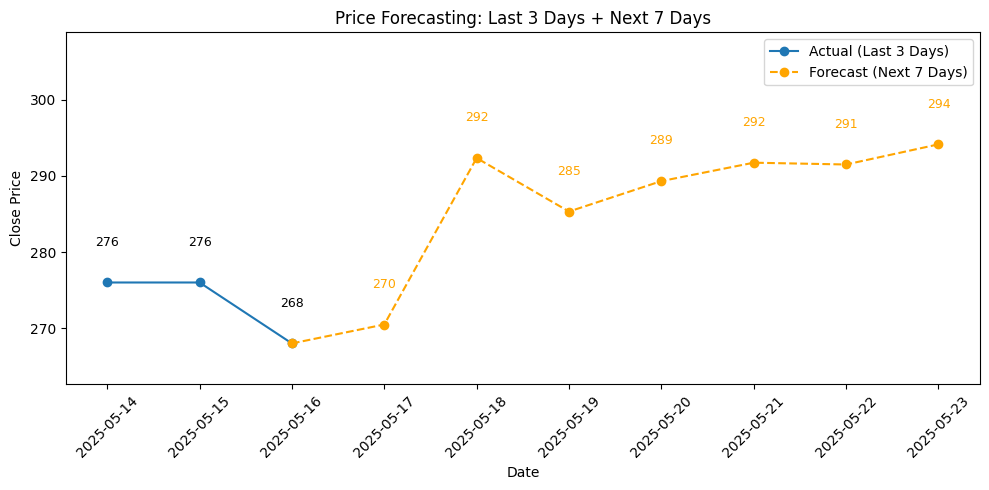

In [19]:
# Forecast
forecast_xgb = forecast_future(model_xgb, df_clean, scaler_x, scaler_y, target_columns, feature_columns, best_window_xgb, n_future=7)

# Visualisasi prediksi 'Close'
visualize_forecast(df_clean, forecast_xgb, tgt, n_future=7, last_n_days=3)

In [20]:
# Evaluasi di Data data training
# Prediksi terhadap data training (rekonstruksi)
y_pred = model_xgb.predict(x_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_scaled)

# Evaluasi semua target
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_true_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_true_inv[:, i], y_pred_inv[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")


Close - MAPE: 0.02%, R²: 1.000


In [21]:
# Evaluasi di Data Test (7 Hari Terakhir)

df_test = df_clean[-(best_window_xgb + 7):]  # ambil untuk lag dan 7 hari
df_test_ml = create_multivariate_lag_features(df_test, target_columns, feature_columns, best_window_xgb)

x_test = df_test_ml.drop(columns=target_columns)
y_test = df_test_ml[target_columns]
x_test_scaled = scaler_x.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)

y_test_pred_scaled = model_xgb.predict(x_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_scaled)

print("\n[Hold-out Test Evaluation]")
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_test_true[:, i], y_test_pred[:, i])
    r2 = r2_score(y_test_true[:, i], y_test_pred[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")



[Hold-out Test Evaluation]
Close - MAPE: 0.02%, R²: 1.000


In [22]:
close_point_xgb = pd.DataFrame({
    'Date': list(future_dates),
    'Close': list(forecast_xgb.reshape(1,-1)[0])
})
close_point_xgb

,Date,Close
0,2025-05-17,270.483588
1,2025-05-18,292.338925
2,2025-05-19,285.314151
3,2025-05-20,289.312610
4,2025-05-21,291.727906
5,2025-05-22,291.491931
6,2025-05-23,294.135724


---
### FORECASTING WITH SEASONAL DECOMPOSE

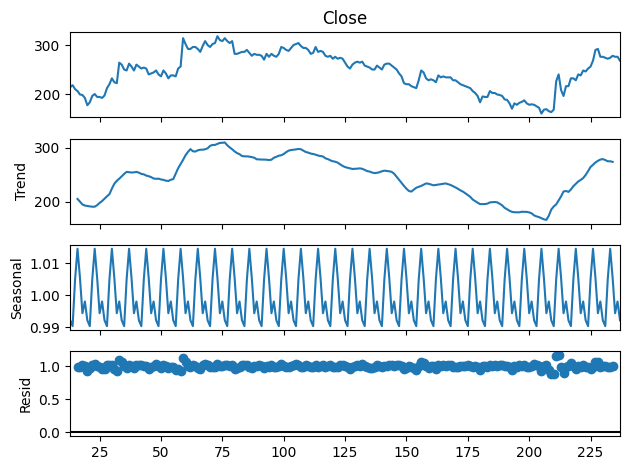

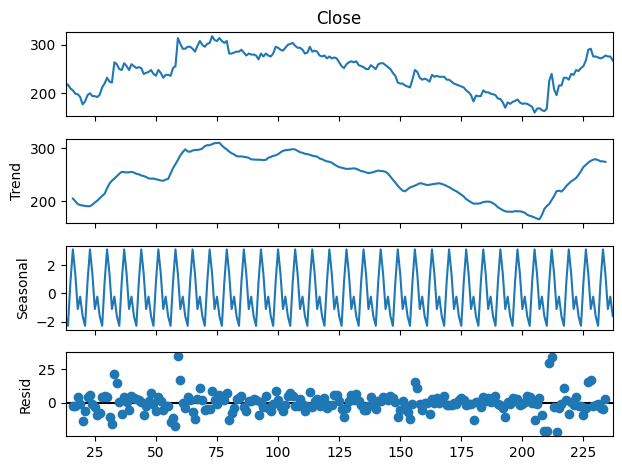

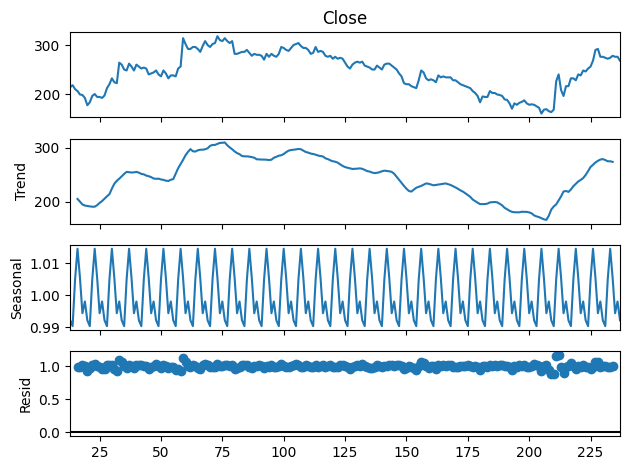

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df_clean[tgt], period=7, model='additive')
result_mul = seasonal_decompose(df_clean[tgt], period=7, model='multiplicative')
result_add.plot()
result_mul.plot()

In [31]:
mvg = df_clean[tgt].reset_index()
mvg['Moving Average'] = mvg[tgt].rolling(window=best_window).mean()
mvg[[tgt, 'Moving Average']].head(15)

,Close,Moving Average
0,214.0,NaN
1,218.0,NaN
2,210.0,NaN
3,206.0,NaN
4,199.0,NaN
5,198.0,NaN
6,192.0,NaN
7,177.0,NaN
8,183.0,NaN
9,196.0,199.3


In [32]:
stocks_data = list(df_clean[tgt].values)

n_future = 7
window = best_window
forecast_ma = []

for _ in range(n_future):
    if len(stocks_data) < window:
        avg = np.mean(stocks_data)
    else:
        print(stocks_data[-window:])
        avg = np.mean(stocks_data[-window:])
    forecast_ma.append(avg)
    stocks_data.append(avg)

[292.0, 276.0, 276.0, 274.0, 272.0, 274.0, 278.0, 276.0, 276.0, 268.0]
[276.0, 276.0, 274.0, 272.0, 274.0, 278.0, 276.0, 276.0, 268.0, 276.2]
[276.0, 274.0, 272.0, 274.0, 278.0, 276.0, 276.0, 268.0, 276.2, 274.62]
[274.0, 272.0, 274.0, 278.0, 276.0, 276.0, 268.0, 276.2, 274.62, 274.48199999999997]
[272.0, 274.0, 278.0, 276.0, 276.0, 268.0, 276.2, 274.62, 274.48199999999997, 274.3302]
[274.0, 278.0, 276.0, 276.0, 268.0, 276.2, 274.62, 274.48199999999997, 274.3302, 274.36321999999996]
[278.0, 276.0, 276.0, 268.0, 276.2, 274.62, 274.48199999999997, 274.3302, 274.36321999999996, 274.59954200000004]


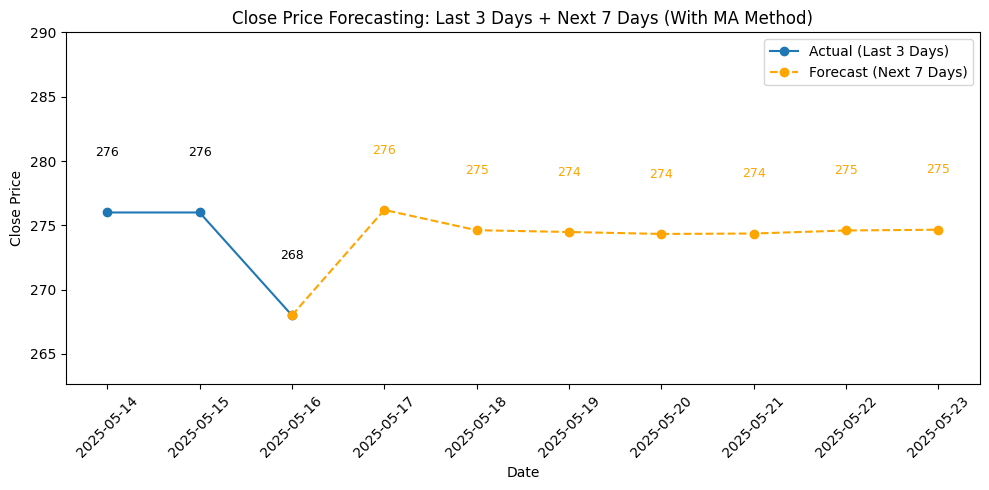

In [33]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + forecast_ma
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'Close Price Forecasting: Last 3 Days + Next 7 Days (With MA Method)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [34]:
close_point_ma = pd.DataFrame({
    'Date': list(future_dates),
    'Close': forecast_ma
})
close_point_ma

,Date,Close
0,2025-05-17,276.200000
1,2025-05-18,274.620000
2,2025-05-19,274.482000
3,2025-05-20,274.330200
4,2025-05-21,274.363220
5,2025-05-22,274.599542
6,2025-05-23,274.659496


### FORECASTING WITH EXPONENTIAL SMOOTHING

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

double = ExponentialSmoothing(df_clean[tgt].values, trend='mul', seasonal='mul', seasonal_periods=7).fit()

day = 7
double_forecast = double.forecast(steps=day)

print(f'prediksi harga berikutnya: {double_forecast}')

prediksi harga berikutnya: [267.43253003 270.16107211 272.73604916 271.17319694 269.03812488
 269.86891967 268.4265412 ]


c:\Programming\.vscode\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


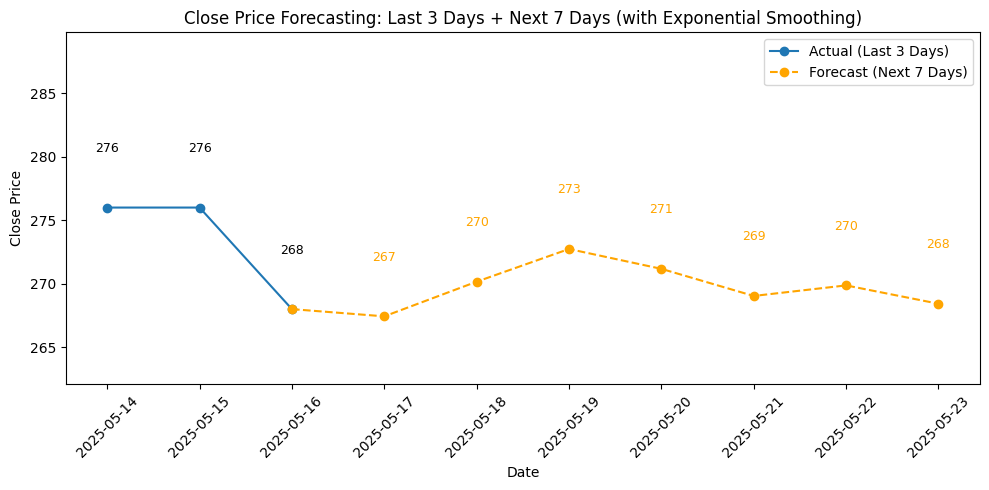

In [36]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + list(double_forecast)
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'Close Price Forecasting: Last 3 Days + Next 7 Days (with Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [37]:
close_point_es = pd.DataFrame({
    'Date': list(future_dates),
    'Close': list(double_forecast)
})
close_point_es

,Date,Close
0,2025-05-17,267.432530
1,2025-05-18,270.161072
2,2025-05-19,272.736049
3,2025-05-20,271.173197
4,2025-05-21,269.038125
5,2025-05-22,269.868920
6,2025-05-23,268.426541


### FORECASTING WITH SARIMAX

In [38]:
def create_lag_features(series, window=3):
    df_lag = pd.DataFrame()
    for i in range(1, window + 1):
        df_lag[f'lag_{i}'] = series.shift(i)
    df_lag['target'] = series.values
    df_lag.dropna(inplace=True)
    return df_lag

In [39]:
df_arima = df.copy()
df_arima['Date'] = pd.to_datetime(df_arima['Date'], format="%b %d, %Y")
df_arima = df_arima.set_index('Date')
df_arima = df_arima.resample('D').ffill()

window = 3
df_ml_arima = create_lag_features(df_arima[tgt], window)
df_ml_arima

,lag_1,lag_2,lag_3,target
Date,,,,
2024-05-19,228.0,228.0,228.0,228.0
2024-05-20,228.0,228.0,228.0,232.0
2024-05-21,232.0,228.0,228.0,226.0
2024-05-22,226.0,232.0,228.0,224.0
2024-05-23,224.0,226.0,232.0,224.0
...,...,...,...,...
2025-05-12,278.0,278.0,278.0,278.0
2025-05-13,278.0,278.0,278.0,278.0
2025-05-14,278.0,278.0,278.0,276.0


c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

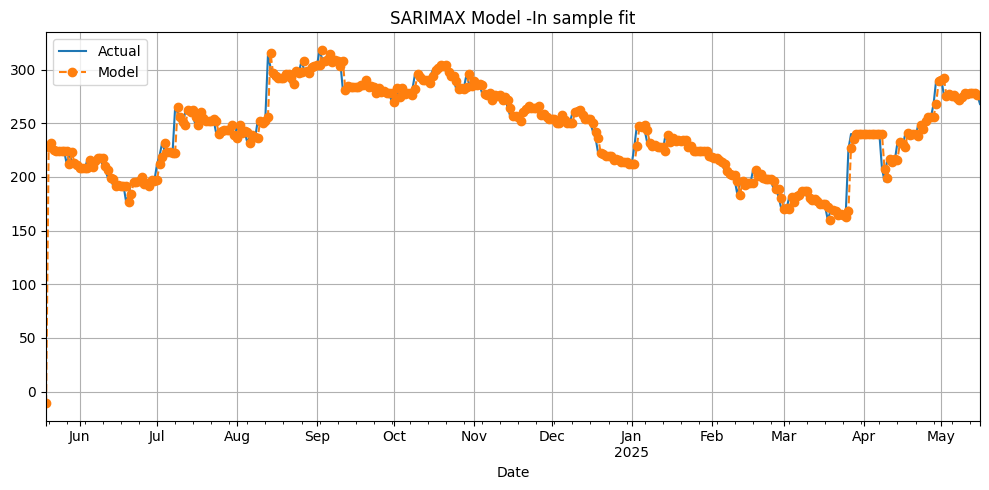

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

# len_train = int(len(df_ml) * 0.8)
train = df_ml_arima
# test = df_ml[len_train:]
# Ensure all inputs are numeric
train['target'] = pd.to_numeric(train['target'], errors='coerce')
train[['lag_1', 'lag_2', 'lag_3']] = train[['lag_1', 'lag_2', 'lag_3']].apply(pd.to_numeric, errors='coerce')


train.index.freq = 'D'
auto = auto_arima(
    train['target'],
    exogenous=train[['lag_1', 'lag_2', 'lag_3']],
    seasonal=True,
    m=4,
    trace=False,
    suppress_warning=True,
    error_action='ignore',
    stepwise=True
)

p, d, q = auto.order
P, D, Q, s = auto.seasonal_order

model = SARIMAX(
    train['target'],
    exog=train[['lag_1', 'lag_2', 'lag_3']],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s)
)
model_fit = model.fit()

predictions = model_fit.predict(
    start=train.index[0],
    end=train.index[-1],
    exog=train[['lag_1', 'lag_2', 'lag_3']]
)

train['target'].plot(label='Actual', figsize=(10,5), legend=True)
predictions.plot(label='Model', linestyle='--', marker='o', legend=True)
plt.title('SARIMAX Model -In sample fit')
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
last_values = list(df_ml_arima['target'].values[-3:])
n_future = 7
forecast_srmx= []

for _ in range(n_future):
    exog_future = pd.DataFrame([{
        'lag_1': last_values[-1],
        'lag_2': last_values[-2],
        'lag_3': last_values[-3]
    }])
    # print(exog_future)
    next_pred = model_fit.forecast(steps=1, exog=exog_future).iloc[0]
    forecast_srmx.append(next_pred)
    last_values.append(next_pred)

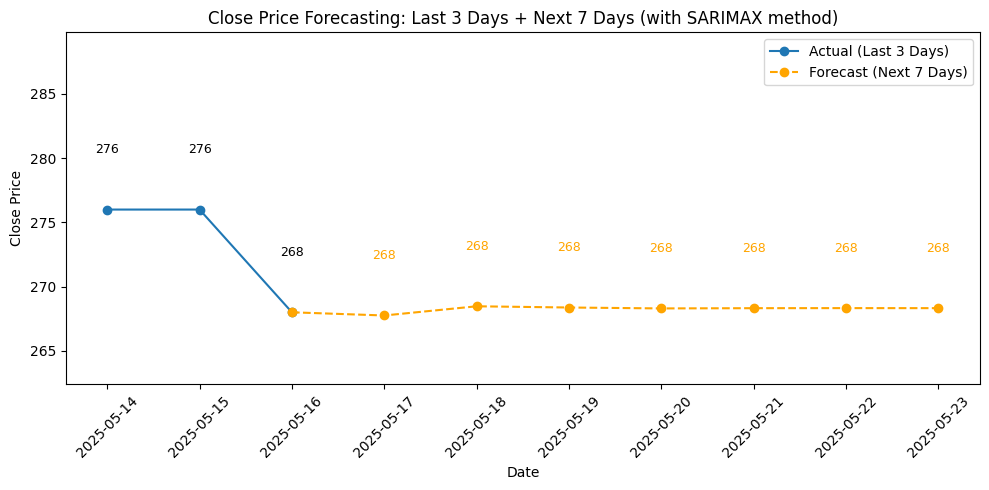

In [42]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + list(forecast_srmx)
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'Close Price Forecasting: Last 3 Days + Next 7 Days (with SARIMAX method)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [43]:
close_point_srmx = pd.DataFrame({
    'Date': list(future_dates),
    'Close': list(forecast_srmx)
})
close_point_srmx

,Date,Close
0,2025-05-17,267.751829
1,2025-05-18,268.467869
2,2025-05-19,268.372847
3,2025-05-20,268.301384
4,2025-05-21,268.320282
5,2025-05-22,268.325621
6,2025-05-23,268.322837


## HIGH POINT ANALYSIS

Melakukan proyeksi/forecast terhadap 'HIGH' point dari saham ADHI dengan menggunakan 4 metode: yakni dengan Machine Learning (menggunakan `RandomForestRegressor` dan `XGBoostRegressor`), Moving Average, Exponential Smoothing dan SARIMAX.

### PERMODELAN DENGAN MACHINE LEARNING

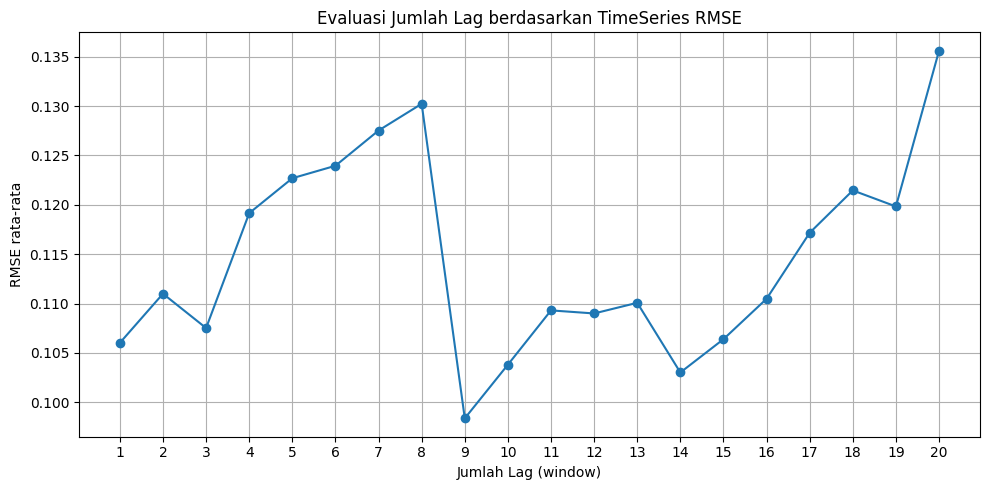

In [23]:
tgt = 'High'
 
df_clean = preprocess_data(df)
df_clean = add_technical_indicators(df_clean, tgt)
df_clean = remove_outliers_iqr(df_clean, tgt)

# target & fitur
target_columns = [tgt]
feature_columns = ['Open', 'Close', 'Low','MA_5', 'MA_10', 'EMA_12', 'EMA_26', 'MACD', 'Momentum', 'Volatility_5', 'Price_Range', 'RSI']

# Cari window terbaik
results_rf = grid_search_best_lag(df_clean, target_columns, feature_columns, RandomForestRegressor(n_estimators=100, random_state=42), )
plot_grid_results(results_rf)
best_window_rf = min(results_rf, key=lambda x: x[1])[0]
rf_rmse = min(results_rf, key=lambda x: x[1])[1]

c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are

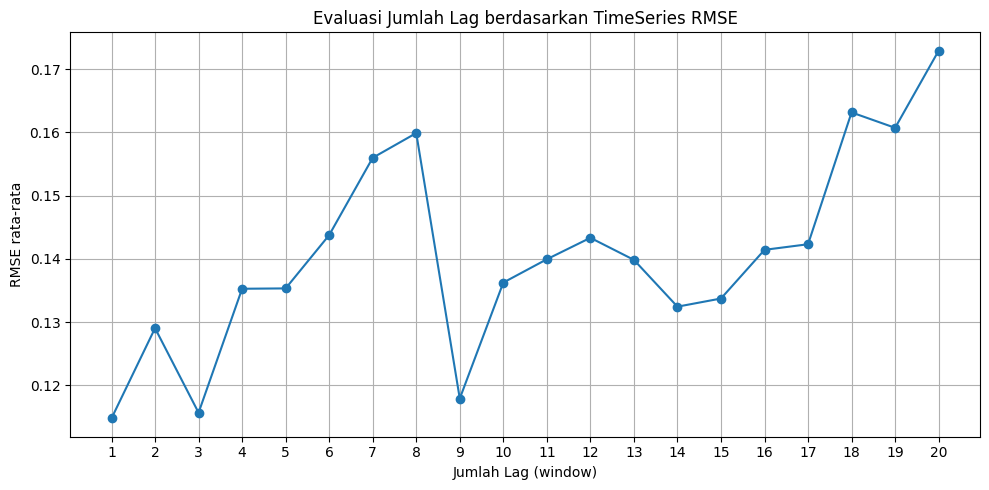

In [24]:
results_xgb = grid_search_best_lag(df_clean, target_columns, feature_columns, XGBRegressor(n_estimators=100, dart_normalized_type='forest'), )
plot_grid_results(results_xgb)
best_window_xgb = min(results_xgb, key=lambda x: x[1])[0]
xgb_rmse = min(results_xgb, key=lambda x: x[1])[1]

#### PREDIKSI DENGAN RANDOM FOREST

In [25]:
df_ml = create_multivariate_lag_features(df_clean, target_columns, feature_columns, best_window)
x = df_ml.drop(columns=target_columns)
y = df_ml[target_columns]

In [26]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [27]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(x_scaled, y_scaled)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

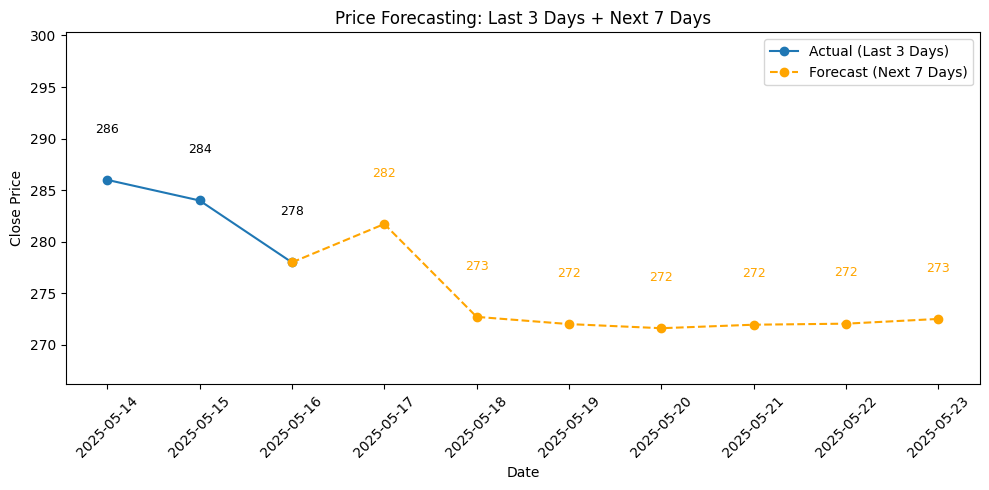

In [28]:
# Forecast
forecast = forecast_future(model, df_clean, scaler_x, scaler_y, target_columns, feature_columns, best_window, n_future=7)

# Visualisasi prediksi 'Close'
visualize_forecast(df_clean, forecast, tgt, n_future=7, last_n_days=3)

In [29]:
# Evaluasi di Data data training

from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Prediksi terhadap data training (rekonstruksi)
y_pred = model.predict(x_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_scaled)

# Evaluasi semua target
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_true_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_true_inv[:, i], y_pred_inv[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")

High - MAPE: 0.91%, R²: 0.992


In [30]:
# Evaluasi di Data Test (7 Hari Terakhir)

df_test = df_clean[-(best_window + 7):]  # ambil untuk lag dan 7 hari
df_test_ml = create_multivariate_lag_features(df_test, target_columns, feature_columns, best_window)

x_test = df_test_ml.drop(columns=target_columns)
y_test = df_test_ml[target_columns]
x_test_scaled = scaler_x.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)

y_test_pred_scaled = model.predict(x_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_scaled)

print("\n[Hold-out Test Evaluation]")
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_test_true[:, i], y_test_pred[:, i])
    r2 = r2_score(y_test_true[:, i], y_test_pred[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")


[Hold-out Test Evaluation]
High - MAPE: 0.45%, R²: 0.793


In [31]:
high_point_macl = pd.DataFrame({
    'Date': list(future_dates),
    'High': list(forecast.reshape(1,-1)[0])
})
high_point_macl

,Date,High
0,2025-05-17,281.72
1,2025-05-18,272.72
2,2025-05-19,272.02
3,2025-05-20,271.62
4,2025-05-21,271.96
5,2025-05-22,272.06
6,2025-05-23,272.52


#### PREDIKSI DENGAN XGBOOST

In [32]:
# Data untuk training
df_ml = create_multivariate_lag_features(df_clean, target_columns, feature_columns, best_window_xgb)
x = df_ml.drop(columns=target_columns)
y = df_ml[target_columns]

In [33]:
# Normalisasi
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [34]:
model_xgb = MultiOutputRegressor(XGBRegressor(n_estimators=100, dart_normalized_type='forest'))
model_xgb.fit(x_scaled, y_scaled)

c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            dart_normalized_type='forest',
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None, ...))

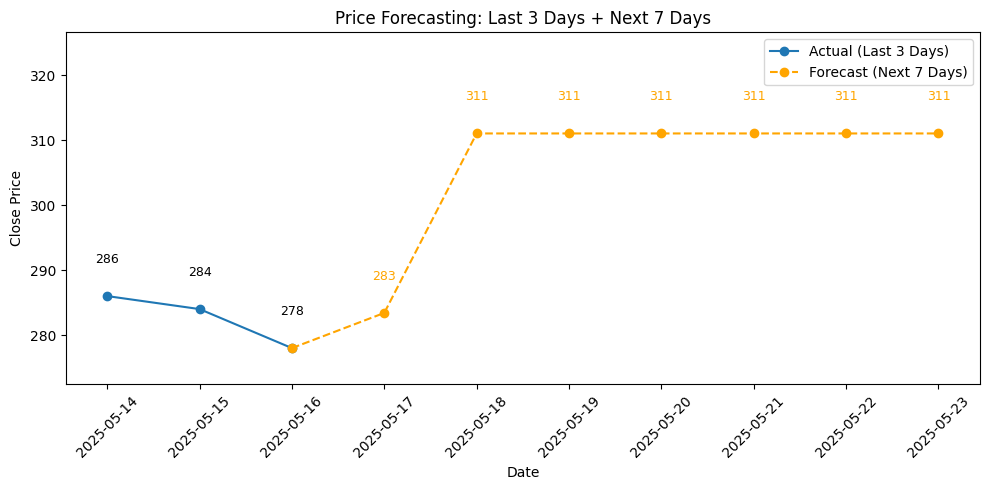

In [35]:
# Forecast
forecast_xgb = forecast_future(model_xgb, df_clean, scaler_x, scaler_y, target_columns, feature_columns, best_window_xgb, n_future=7)

# Visualisasi prediksi 'Close'
visualize_forecast(df_clean, forecast_xgb, tgt, n_future=7, last_n_days=3)

In [36]:
# Evaluasi di Data data training
# Prediksi terhadap data training (rekonstruksi)
y_pred = model_xgb.predict(x_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_scaled)

# Evaluasi semua target
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_true_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_true_inv[:, i], y_pred_inv[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")


High - MAPE: 0.05%, R²: 1.000


In [37]:
# Evaluasi di Data Test (7 Hari Terakhir)

df_test = df_clean[-(best_window_xgb + 7):]  # ambil untuk lag dan 7 hari
df_test_ml = create_multivariate_lag_features(df_test, target_columns, feature_columns, best_window_xgb)

x_test = df_test_ml.drop(columns=target_columns)
y_test = df_test_ml[target_columns]
x_test_scaled = scaler_x.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)

y_test_pred_scaled = model_xgb.predict(x_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_scaled)

print("\n[Hold-out Test Evaluation]")
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_test_true[:, i], y_test_pred[:, i])
    r2 = r2_score(y_test_true[:, i], y_test_pred[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")



[Hold-out Test Evaluation]
High - MAPE: 0.05%, R²: 0.997


In [38]:
high_point_xgb = pd.DataFrame({
    'Date': list(future_dates),
    'High': list(forecast_xgb.reshape(1,-1)[0])
})
high_point_xgb

,Date,High
0,2025-05-17,283.410235
1,2025-05-18,311.011302
2,2025-05-19,311.011302
3,2025-05-20,311.011302
4,2025-05-21,311.011302
5,2025-05-22,311.011302
6,2025-05-23,311.011302


---
### FORECASTING WITH SEASONAL DECOMPOSE

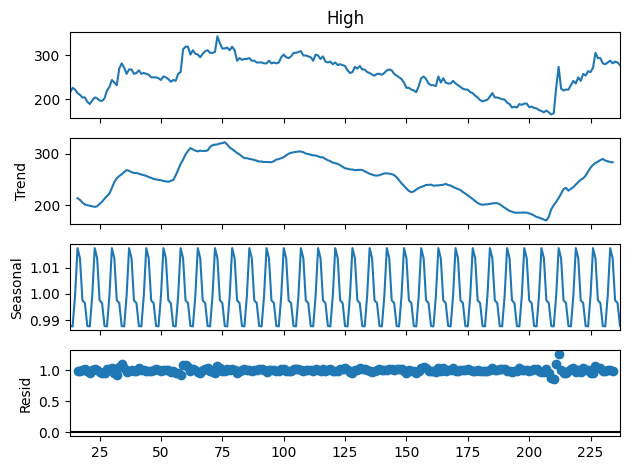

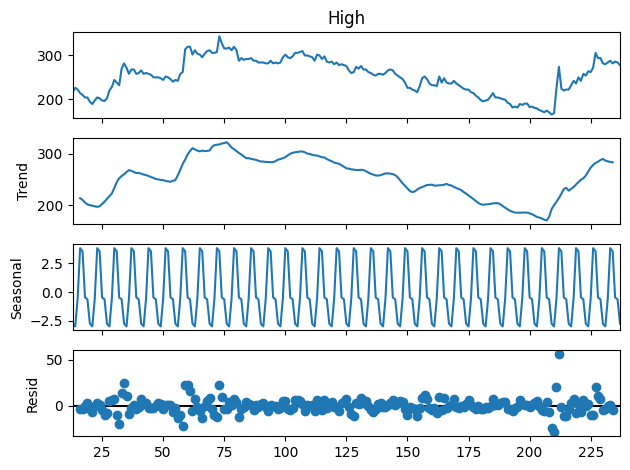

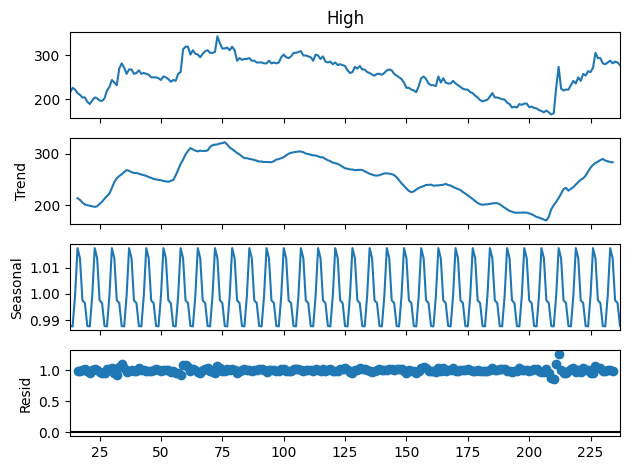

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df_clean[tgt], period=7, model='additive')
result_mul = seasonal_decompose(df_clean[tgt], period=7, model='multiplicative')
result_add.plot()
result_mul.plot()

In [61]:
mvg = df_clean[tgt].reset_index()
mvg['Moving Average'] = mvg[tgt].rolling(window=best_window).mean()
mvg[[tgt, 'Moving Average']].head(15)

,High,Moving Average
0,216.0,NaN
1,226.0,NaN
2,222.0,NaN
3,214.0,NaN
4,210.0,NaN
5,204.0,NaN
6,204.0,NaN
7,194.0,NaN
8,189.0,NaN
9,197.0,207.6


In [62]:
stocks_data = list(df_clean[tgt].values)

n_future = 7
window = best_window
forecast_ma = []

for _ in range(n_future):
    if len(stocks_data) < window:
        avg = np.mean(stocks_data)
    else:
        print(stocks_data[-window:])
        avg = np.mean(stocks_data[-window:])
    forecast_ma.append(avg)
    stocks_data.append(avg)

[294.0, 294.0, 282.0, 280.0, 284.0, 288.0, 282.0, 286.0, 284.0, 278.0]
[294.0, 282.0, 280.0, 284.0, 288.0, 282.0, 286.0, 284.0, 278.0, 285.2]
[282.0, 280.0, 284.0, 288.0, 282.0, 286.0, 284.0, 278.0, 285.2, 284.32]
[280.0, 284.0, 288.0, 282.0, 286.0, 284.0, 278.0, 285.2, 284.32, 283.352]
[284.0, 288.0, 282.0, 286.0, 284.0, 278.0, 285.2, 284.32, 283.352, 283.4872]
[288.0, 282.0, 286.0, 284.0, 278.0, 285.2, 284.32, 283.352, 283.4872, 283.83592]
[282.0, 286.0, 284.0, 278.0, 285.2, 284.32, 283.352, 283.4872, 283.83592, 283.81951200000003]


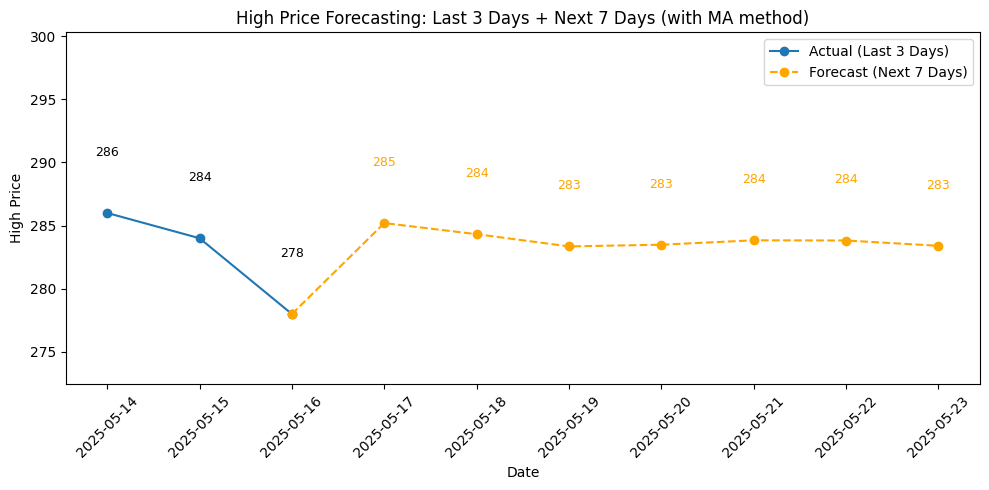

In [63]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + forecast_ma
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'High Price Forecasting: Last 3 Days + Next 7 Days (with MA method)')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [64]:
high_point_ma = pd.DataFrame({
    'Date': list(future_dates),
    'High': forecast_ma
})
high_point_ma

,Date,High
0,2025-05-17,285.200000
1,2025-05-18,284.320000
2,2025-05-19,283.352000
3,2025-05-20,283.487200
4,2025-05-21,283.835920
5,2025-05-22,283.819512
6,2025-05-23,283.401463


### FORECASTING WITH EXPONENTIAL SMOOTHING

In [65]:
double = ExponentialSmoothing(df_clean[tgt].values, trend='mul', seasonal='mul', seasonal_periods=7).fit()

day = 7
double_forecast = double.forecast(steps=day)

print(f'prediksi harga berikutnya: {double_forecast}')

prediksi harga berikutnya: [278.10944387 280.08608399 284.73856834 284.76445381 280.72912329
 280.62740977 278.50353739]


c:\Programming\.vscode\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


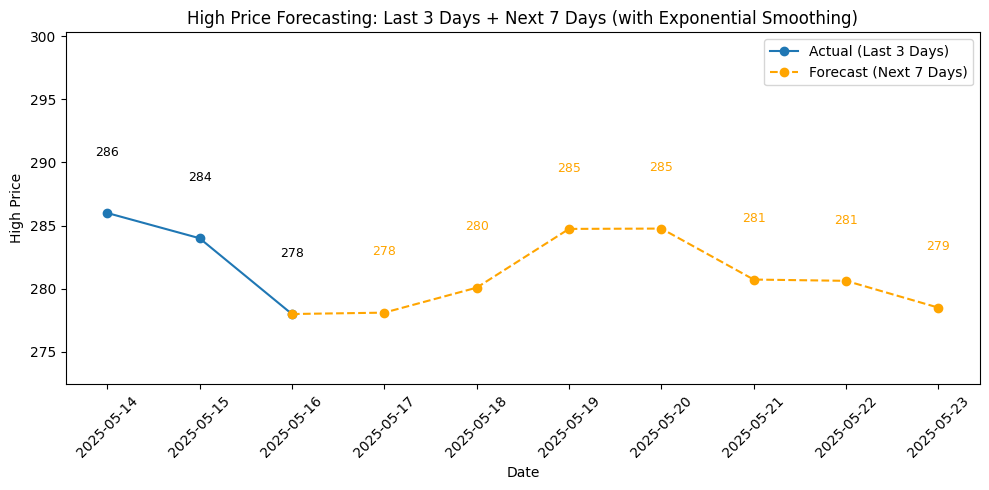

In [66]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + list(double_forecast)
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'High Price Forecasting: Last 3 Days + Next 7 Days (with Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [67]:
high_point_es = pd.DataFrame({
    'Date': list(future_dates),
    'High': list(double_forecast)
})
high_point_es

,Date,High
0,2025-05-17,278.109444
1,2025-05-18,280.086084
2,2025-05-19,284.738568
3,2025-05-20,284.764454
4,2025-05-21,280.729123
5,2025-05-22,280.627410
6,2025-05-23,278.503537


### FORECASTING WITH SARIMAX

In [68]:
window = 3
df_ml_arima = create_lag_features(df_arima[tgt], window)
df_ml_arima

,lag_1,lag_2,lag_3,target
Date,,,,
2024-05-19,232.0,232.0,232.0,232.0
2024-05-20,232.0,232.0,232.0,240.0
2024-05-21,240.0,232.0,232.0,232.0
2024-05-22,232.0,240.0,232.0,228.0
2024-05-23,228.0,232.0,240.0,228.0
...,...,...,...,...
2025-05-12,282.0,282.0,282.0,282.0
2025-05-13,282.0,282.0,282.0,282.0
2025-05-14,282.0,282.0,282.0,286.0


c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

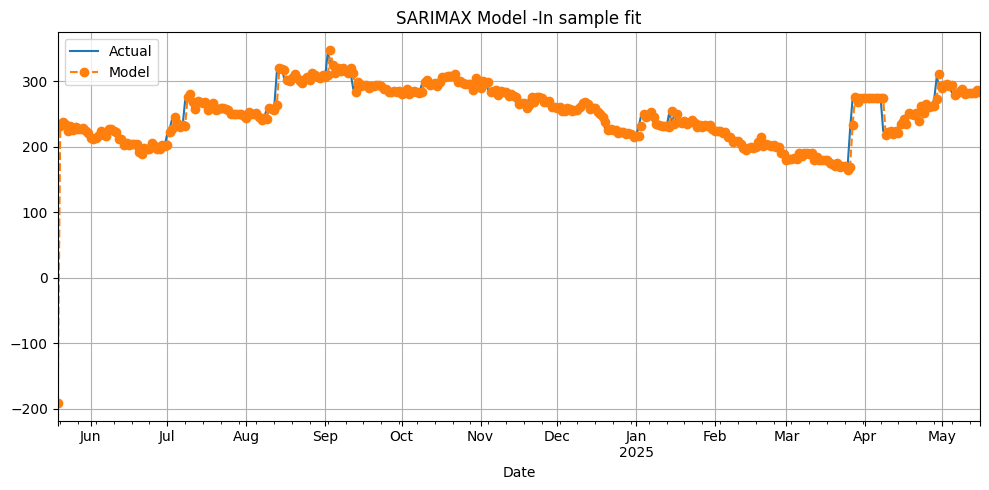

In [69]:
train = df_ml_arima
train['target'] = pd.to_numeric(train['target'], errors='coerce')
train[['lag_1', 'lag_2', 'lag_3']] = train[['lag_1', 'lag_2', 'lag_3']].apply(pd.to_numeric, errors='coerce')


train.index.freq = 'D'
auto = auto_arima(
    train['target'],
    exogenous=train[['lag_1', 'lag_2', 'lag_3']],
    seasonal=True,
    m=4,
    trace=False,
    suppress_warning=True,
    error_action='ignore',
    stepwise=True
)

p, d, q = auto.order
P, D, Q, s = auto.seasonal_order

model = SARIMAX(
    train['target'],
    exog=train[['lag_1', 'lag_2', 'lag_3']],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s)
)
model_fit = model.fit()

predictions = model_fit.predict(
    start=train.index[0],
    end=train.index[-1],
    exog=train[['lag_1', 'lag_2', 'lag_3']]
)

train['target'].plot(label='Actual', figsize=(10,5), legend=True)
predictions.plot(label='Model', linestyle='--', marker='o', legend=True)
plt.title('SARIMAX Model -In sample fit')
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
last_values = list(df_ml_arima['target'].values[-3:])
n_future = 7
forecast_srmx= []

for _ in range(n_future):
    exog_future = pd.DataFrame([{
        'lag_1': last_values[-1],
        'lag_2': last_values[-2],
        'lag_3': last_values[-3]
    }])
    # print(exog_future)
    next_pred = model_fit.forecast(steps=1, exog=exog_future).iloc[0]
    forecast_srmx.append(next_pred)
    last_values.append(next_pred)

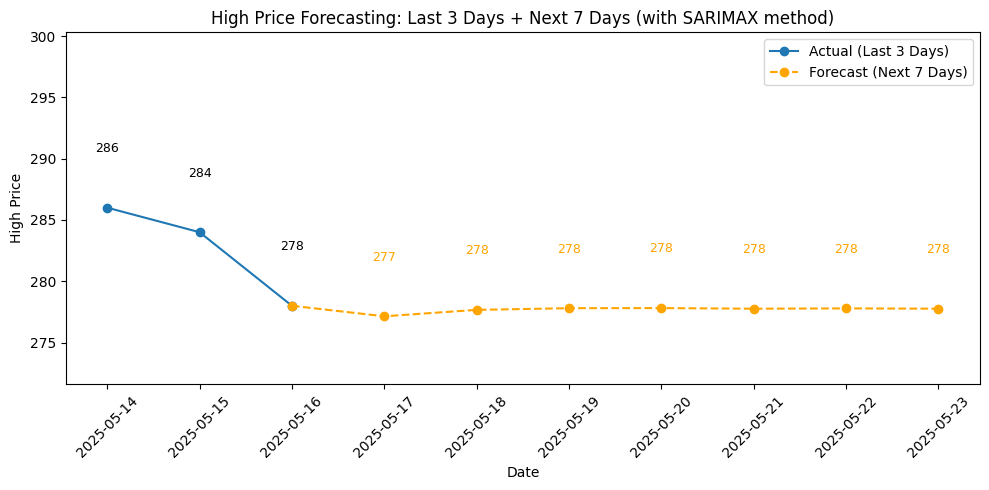

In [71]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + list(forecast_srmx)
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'High Price Forecasting: Last 3 Days + Next 7 Days (with SARIMAX method)')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [72]:
high_point_srmx = pd.DataFrame({
    'Date': list(future_dates),
    'High': list(forecast_srmx)
})
high_point_srmx

,Date,High
0,2025-05-17,277.142516
1,2025-05-18,277.666297
2,2025-05-19,277.801850
3,2025-05-20,277.810861
4,2025-05-21,277.759754
5,2025-05-22,277.786774
6,2025-05-23,277.761847


## LOW POINT ANALYSIS

Melakukan proyeksi/forecast terhadap 'LOW' point dari saham ADHI dengan menggunakan 4 metode: yakni dengan Machine Learning (menggunakan `RandomForestRegressor` dan `XGBoostRegressor`), Moving Average, Exponential Smoothing dan SARIMAX.

### PERMODELAN DENGAN MACHINE LEARNING

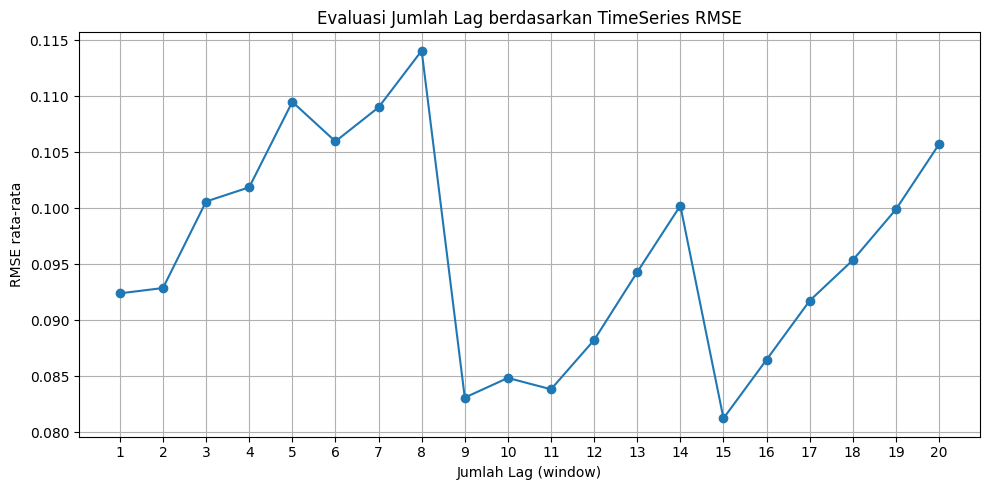

In [39]:
tgt = 'Low'
 
df_clean = preprocess_data(df)
df_clean = add_technical_indicators(df_clean, tgt)
df_clean = remove_outliers_iqr(df_clean, tgt)

# target & fitur
target_columns = [tgt]
feature_columns = ['Open', 'Close', 'High','MA_5', 'MA_10', 'EMA_12', 'EMA_26', 'MACD', 'Momentum', 'Volatility_5', 'Price_Range', 'RSI']

# Cari window terbaik
results_rf = grid_search_best_lag(df_clean, target_columns, feature_columns, RandomForestRegressor(n_estimators=100, random_state=42), )
plot_grid_results(results_rf)
best_window_rf = min(results_rf, key=lambda x: x[1])[0]
rf_rmse = min(results_rf, key=lambda x: x[1])[1]

c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are

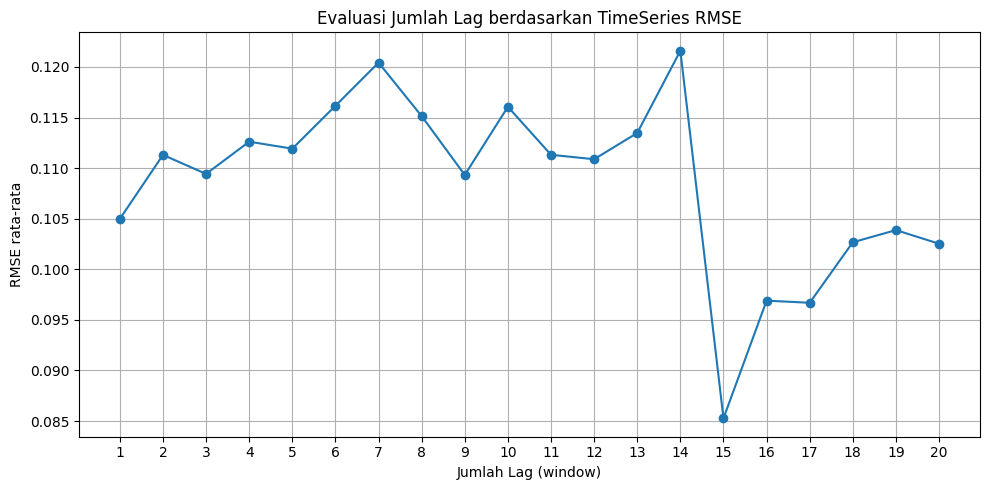

In [40]:
results_xgb = grid_search_best_lag(df_clean, target_columns, feature_columns, XGBRegressor(n_estimators=100, dart_normalized_type='forest'), )
plot_grid_results(results_xgb)
best_window_xgb = min(results_xgb, key=lambda x: x[1])[0]
xgb_rmse = min(results_xgb, key=lambda x: x[1])[1]

#### PREDIKSI DENGAN RANDOM FOREST

In [41]:
df_ml = create_multivariate_lag_features(df_clean, target_columns, feature_columns, best_window)
x = df_ml.drop(columns=target_columns)
y = df_ml[target_columns]

In [42]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [43]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(x_scaled, y_scaled)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

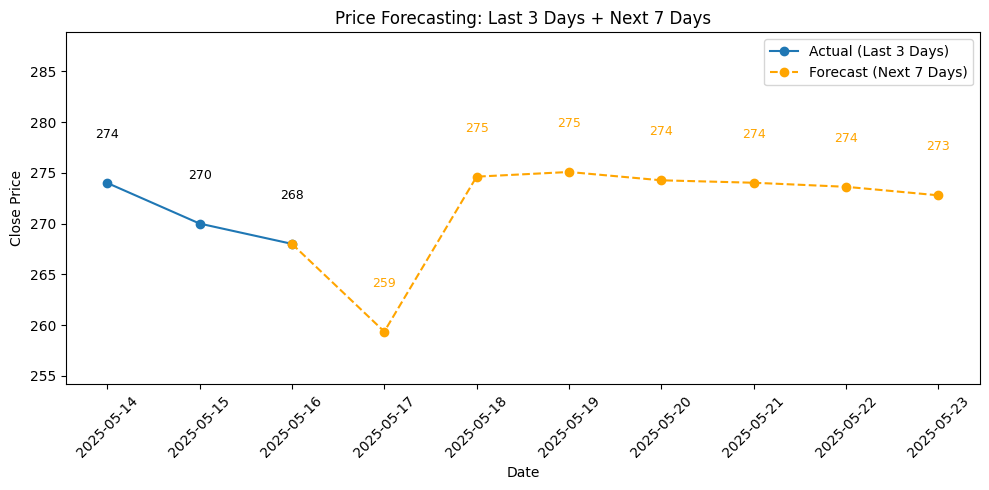

In [44]:
# Forecast
forecast = forecast_future(model, df_clean, scaler_x, scaler_y, target_columns, feature_columns, best_window, n_future=7)

# Visualisasi prediksi 'Close'
visualize_forecast(df_clean, forecast, tgt, n_future=7, last_n_days=3)

In [45]:
# Evaluasi di Data data training

from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Prediksi terhadap data training (rekonstruksi)
y_pred = model.predict(x_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_scaled)

# Evaluasi semua target
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_true_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_true_inv[:, i], y_pred_inv[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")

Low - MAPE: 0.68%, R²: 0.997


In [46]:
# Evaluasi di Data Test (7 Hari Terakhir)

df_test = df_clean[-(best_window + 7):]  # ambil untuk lag dan 7 hari
df_test_ml = create_multivariate_lag_features(df_test, target_columns, feature_columns, best_window)

x_test = df_test_ml.drop(columns=target_columns)
y_test = df_test_ml[target_columns]
x_test_scaled = scaler_x.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)

y_test_pred_scaled = model.predict(x_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_scaled)

print("\n[Hold-out Test Evaluation]")
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_test_true[:, i], y_test_pred[:, i])
    r2 = r2_score(y_test_true[:, i], y_test_pred[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")


[Hold-out Test Evaluation]
Low - MAPE: 0.37%, R²: 0.566


In [47]:
low_point_macl = pd.DataFrame({
    'Date': list(future_dates),
    'Low': list(forecast.reshape(1,-1)[0])
})
low_point_macl

,Date,Low
0,2025-05-17,259.36
1,2025-05-18,274.62
2,2025-05-19,275.08
3,2025-05-20,274.26
4,2025-05-21,274.02
5,2025-05-22,273.62
6,2025-05-23,272.78


#### PREDIKSI DENGAN XGBOOST

In [48]:
# Data untuk training
df_ml = create_multivariate_lag_features(df_clean, target_columns, feature_columns, best_window_xgb)
x = df_ml.drop(columns=target_columns)
y = df_ml[target_columns]

In [49]:
# Normalisasi
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [50]:
model_xgb = MultiOutputRegressor(XGBRegressor(n_estimators=100, dart_normalized_type='forest'))
model_xgb.fit(x_scaled, y_scaled)

c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            dart_normalized_type='forest',
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None, ...))

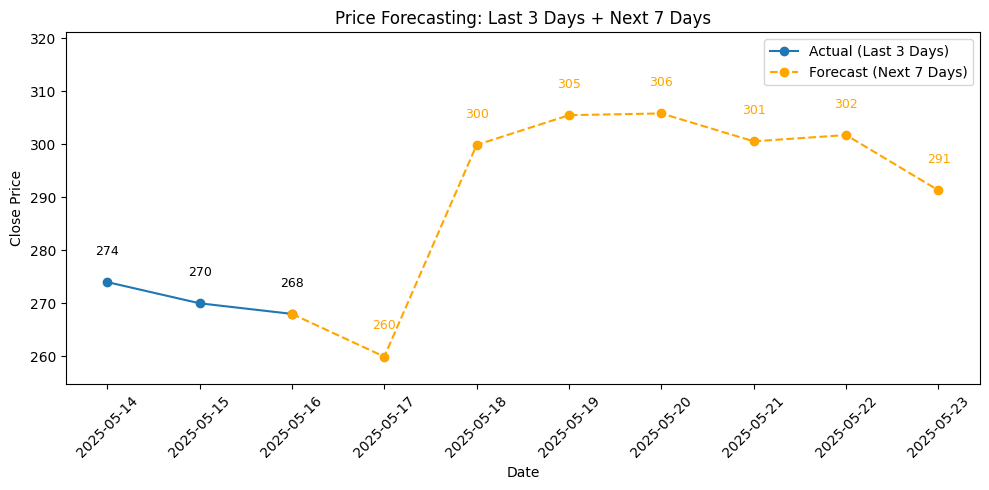

In [51]:
# Forecast
forecast_xgb = forecast_future(model_xgb, df_clean, scaler_x, scaler_y, target_columns, feature_columns, best_window_xgb, n_future=7)

# Visualisasi prediksi 'Close'
visualize_forecast(df_clean, forecast_xgb, tgt, n_future=7, last_n_days=3)

In [52]:
# Evaluasi di Data data training
# Prediksi terhadap data training (rekonstruksi)
y_pred = model_xgb.predict(x_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_scaled)

# Evaluasi semua target
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_true_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_true_inv[:, i], y_pred_inv[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")


Low - MAPE: 0.02%, R²: 1.000


In [53]:
# Evaluasi di Data Test (7 Hari Terakhir)

df_test = df_clean[-(best_window_xgb + 7):]  # ambil untuk lag dan 7 hari
df_test_ml = create_multivariate_lag_features(df_test, target_columns, feature_columns, best_window_xgb)

x_test = df_test_ml.drop(columns=target_columns)
y_test = df_test_ml[target_columns]
x_test_scaled = scaler_x.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)

y_test_pred_scaled = model_xgb.predict(x_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_scaled)

print("\n[Hold-out Test Evaluation]")
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_test_true[:, i], y_test_pred[:, i])
    r2 = r2_score(y_test_true[:, i], y_test_pred[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")



[Hold-out Test Evaluation]
Low - MAPE: 0.03%, R²: 0.998


In [54]:
low_point_xgb = pd.DataFrame({
    'Date': list(future_dates),
    'Low': list(forecast_xgb.reshape(1,-1)[0])
})
low_point_xgb

,Date,Low
0,2025-05-17,259.932327
1,2025-05-18,299.866371
2,2025-05-19,305.467396
3,2025-05-20,305.797844
4,2025-05-21,300.538025
5,2025-05-22,301.722879
6,2025-05-23,291.302929


---
### FORECASTING WITH SEASONAL DECOMPOSE

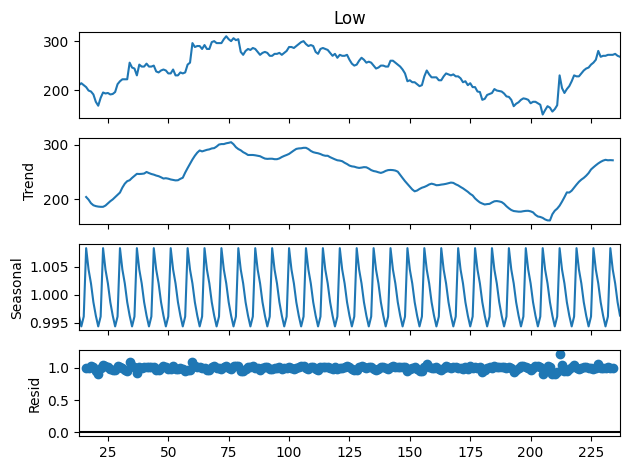

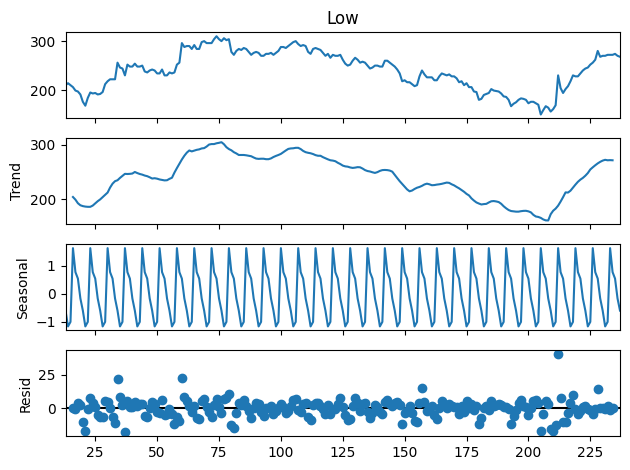

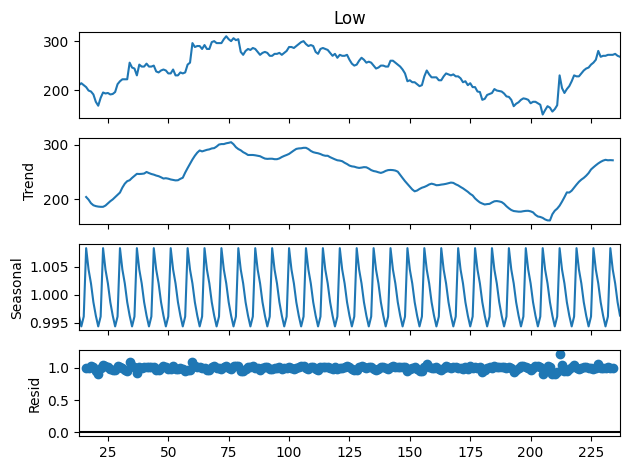

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df_clean[tgt], period=7, model='additive')
result_mul = seasonal_decompose(df_clean[tgt], period=7, model='multiplicative')
result_add.plot()
result_mul.plot()

In [90]:
mvg = df_clean[tgt].reset_index()
mvg['Moving Average'] = mvg[tgt].rolling(window=best_window).mean()
mvg[[tgt, 'Moving Average']].head(15)

,Low,Moving Average
0,210.0,NaN
1,214.0,NaN
2,210.0,NaN
3,206.0,NaN
4,199.0,NaN
5,197.0,NaN
6,191.0,NaN
7,176.0,NaN
8,168.0,NaN
9,184.0,195.5


In [91]:
stocks_data = list(df_clean[tgt].values)

n_future = 7
window = best_window
forecast_ma = []

for _ in range(n_future):
    if len(stocks_data) < window:
        avg = np.mean(stocks_data)
    else:
        print(stocks_data[-window:])
        avg = np.mean(stocks_data[-window:])
    forecast_ma.append(avg)
    stocks_data.append(avg)

[280.0, 268.0, 270.0, 270.0, 272.0, 272.0, 272.0, 274.0, 270.0, 268.0]
[268.0, 270.0, 270.0, 272.0, 272.0, 272.0, 274.0, 270.0, 268.0, 271.6]
[270.0, 270.0, 272.0, 272.0, 272.0, 274.0, 270.0, 268.0, 271.6, 270.76]
[270.0, 272.0, 272.0, 272.0, 274.0, 270.0, 268.0, 271.6, 270.76, 271.03599999999994]
[272.0, 272.0, 272.0, 274.0, 270.0, 268.0, 271.6, 270.76, 271.03599999999994, 271.1396]
[272.0, 272.0, 274.0, 270.0, 268.0, 271.6, 270.76, 271.03599999999994, 271.1396, 271.25356]
[272.0, 274.0, 270.0, 268.0, 271.6, 270.76, 271.03599999999994, 271.1396, 271.25356, 271.17891599999996]


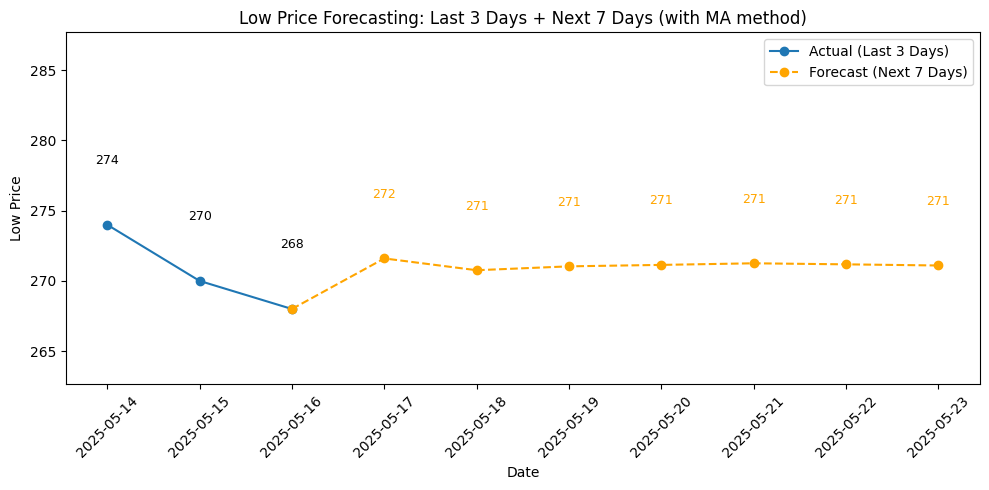

In [92]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + forecast_ma
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'Low Price Forecasting: Last 3 Days + Next 7 Days (with MA method)')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [93]:
low_point_ma = pd.DataFrame({
    'Date': list(future_dates),
    'Low': forecast_ma
})
low_point_ma

,Date,Low
0,2025-05-17,271.600000
1,2025-05-18,270.760000
2,2025-05-19,271.036000
3,2025-05-20,271.139600
4,2025-05-21,271.253560
5,2025-05-22,271.178916
6,2025-05-23,271.096808


### FORECASTING WITH EXPONENTIAL SMOOTHING

In [94]:
double = ExponentialSmoothing(df_clean[tgt].values, trend='mul', seasonal='mul', seasonal_periods=7).fit()

day = 7
double_forecast = double.forecast(steps=day)

print(f'prediksi harga berikutnya: {double_forecast}')

prediksi harga berikutnya: [267.79161297 267.84353228 270.37806927 269.39389826 269.80299697
 269.19990418 268.90766163]


c:\Programming\.vscode\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


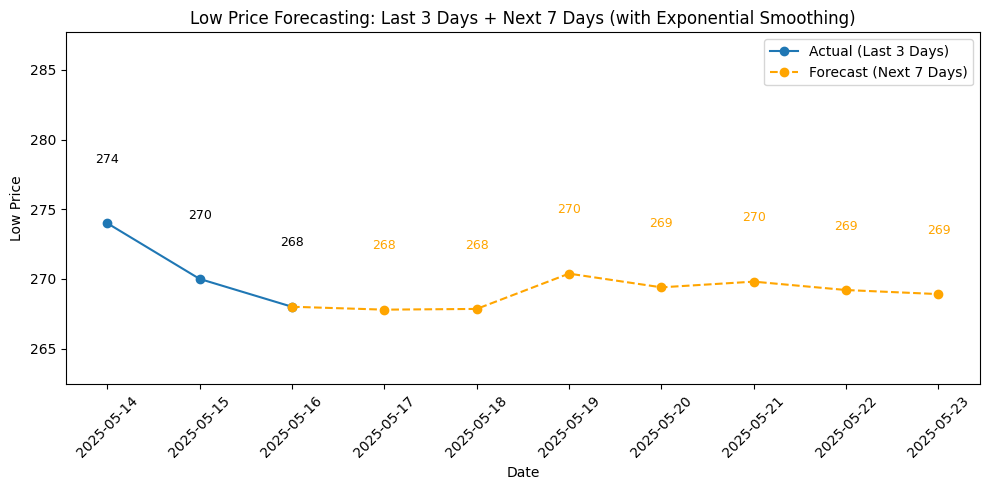

In [95]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + list(double_forecast)
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'Low Price Forecasting: Last 3 Days + Next 7 Days (with Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [96]:
low_point_es = pd.DataFrame({
    'Date': list(future_dates),
    'Low': list(double_forecast)
})
low_point_es

,Date,Low
0,2025-05-17,267.791613
1,2025-05-18,267.843532
2,2025-05-19,270.378069
3,2025-05-20,269.393898
4,2025-05-21,269.802997
5,2025-05-22,269.199904
6,2025-05-23,268.907662


### FORECASTING WITH SARIMAX

In [97]:
window = 3
df_ml_arima = create_lag_features(df_arima[tgt], window)
df_ml_arima

,lag_1,lag_2,lag_3,target
Date,,,,
2024-05-19,226.0,226.0,222.0,226.0
2024-05-20,226.0,226.0,226.0,228.0
2024-05-21,228.0,226.0,226.0,224.0
2024-05-22,224.0,228.0,226.0,222.0
2024-05-23,222.0,224.0,228.0,222.0
...,...,...,...,...
2025-05-12,272.0,272.0,272.0,272.0
2025-05-13,272.0,272.0,272.0,272.0
2025-05-14,272.0,272.0,272.0,274.0


c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

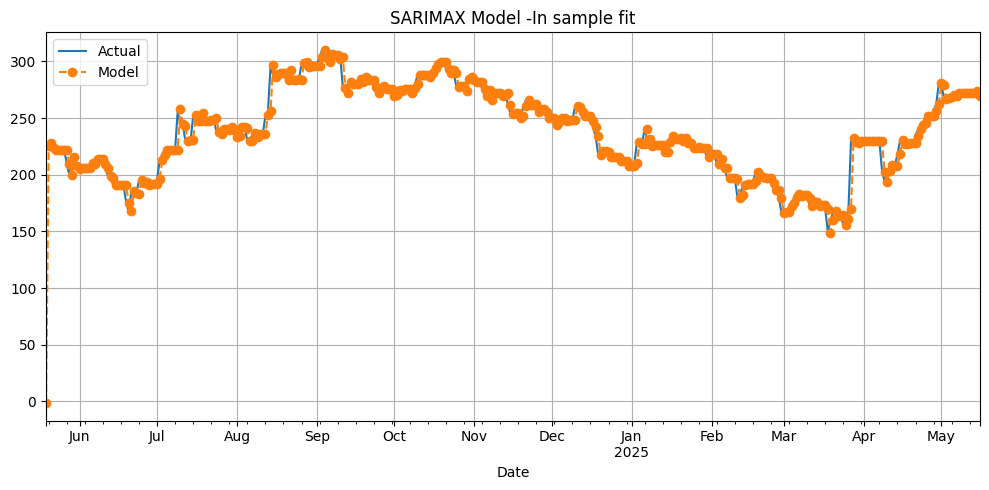

In [98]:
train = df_ml_arima
train['target'] = pd.to_numeric(train['target'], errors='coerce')
train[['lag_1', 'lag_2', 'lag_3']] = train[['lag_1', 'lag_2', 'lag_3']].apply(pd.to_numeric, errors='coerce')


train.index.freq = 'D'
auto = auto_arima(
    train['target'],
    exogenous=train[['lag_1', 'lag_2', 'lag_3']],
    seasonal=True,
    m=4,
    trace=False,
    suppress_warning=True,
    error_action='ignore',
    stepwise=True
)

p, d, q = auto.order
P, D, Q, s = auto.seasonal_order

model = SARIMAX(
    train['target'],
    exog=train[['lag_1', 'lag_2', 'lag_3']],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s)
)
model_fit = model.fit()

predictions = model_fit.predict(
    start=train.index[0],
    end=train.index[-1],
    exog=train[['lag_1', 'lag_2', 'lag_3']]
)

train['target'].plot(label='Actual', figsize=(10,5), legend=True)
predictions.plot(label='Model', linestyle='--', marker='o', legend=True)
plt.title('SARIMAX Model -In sample fit')
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
last_values = list(df_ml_arima['target'].values[-3:])
n_future = 7
forecast_srmx= []

for _ in range(n_future):
    exog_future = pd.DataFrame([{
        'lag_1': last_values[-1],
        'lag_2': last_values[-2],
        'lag_3': last_values[-3]
    }])
    # print(exog_future)
    next_pred = model_fit.forecast(steps=1, exog=exog_future).iloc[0]
    forecast_srmx.append(next_pred)
    last_values.append(next_pred)

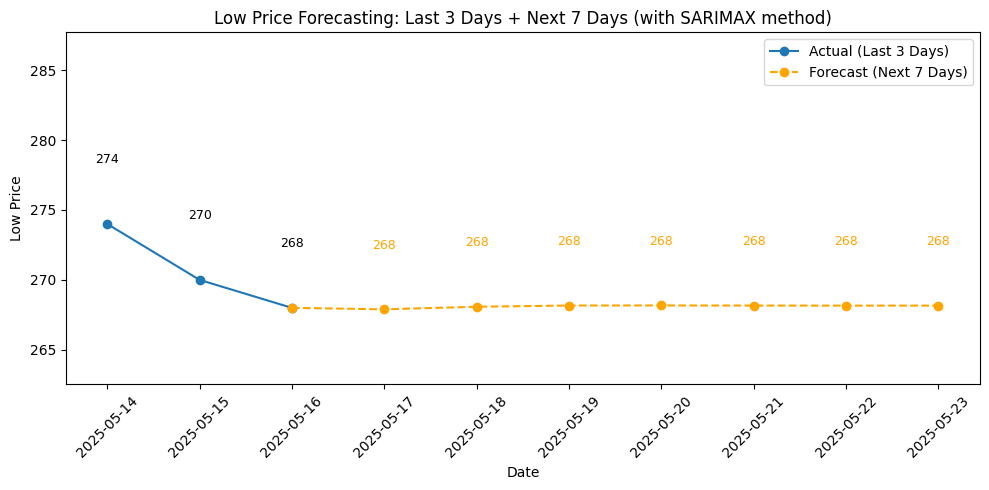

In [100]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + list(forecast_srmx)
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'Low Price Forecasting: Last 3 Days + Next 7 Days (with SARIMAX method)')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [101]:
low_point_srmx = pd.DataFrame({
    'Date': list(future_dates),
    'Low': list(forecast_srmx)
})
low_point_srmx

,Date,Low
0,2025-05-17,267.895235
1,2025-05-18,268.078920
2,2025-05-19,268.166512
3,2025-05-20,268.171605
4,2025-05-21,268.163260
5,2025-05-22,268.159400
6,2025-05-23,268.159162


## OPEN POINT ANALYSIS

Melakukan proyeksi/forecast terhadap 'OPEN' point dari saham ADHI dengan menggunakan 4 metode: yakni dengan Machine Learning (menggunakan `RandomForestRegressor` dan `XGBoostRegressor`), Moving Average, Exponential Smoothing dan SARIMAX.

### PERMODELAN DENGAN MACHINE LEARNING

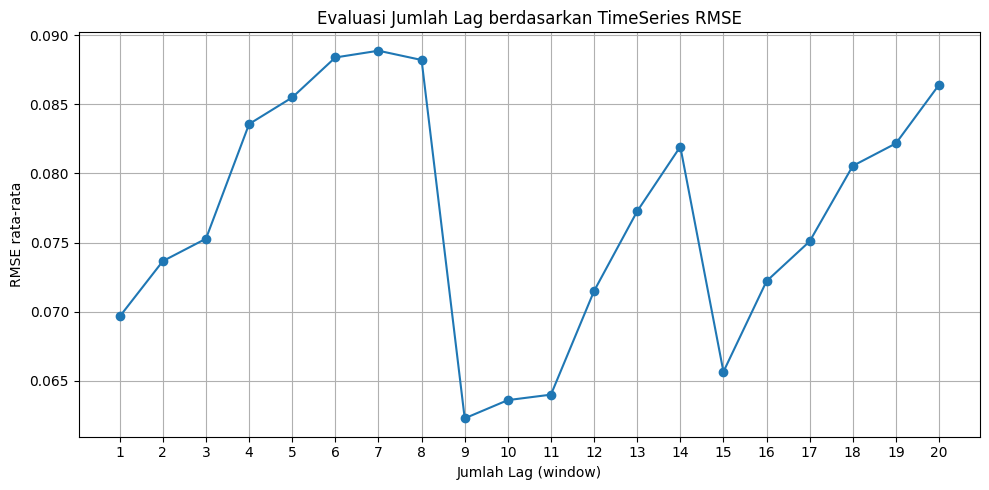

In [55]:
tgt = 'Open'
 
df_clean = preprocess_data(df)
df_clean = add_technical_indicators(df_clean, tgt)
df_clean = remove_outliers_iqr(df_clean, tgt)

# target & fitur
target_columns = [tgt]
feature_columns = ['Low', 'Close', 'High','MA_5', 'MA_10', 'EMA_12', 'EMA_26', 'MACD', 'Momentum', 'Volatility_5', 'Price_Range', 'RSI']

# Cari window terbaik
results_rf = grid_search_best_lag(df_clean, target_columns, feature_columns, RandomForestRegressor(n_estimators=100, random_state=42), )
plot_grid_results(results_rf)
best_window_rf = min(results_rf, key=lambda x: x[1])[0]
rf_rmse = min(results_rf, key=lambda x: x[1])[1]

c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are

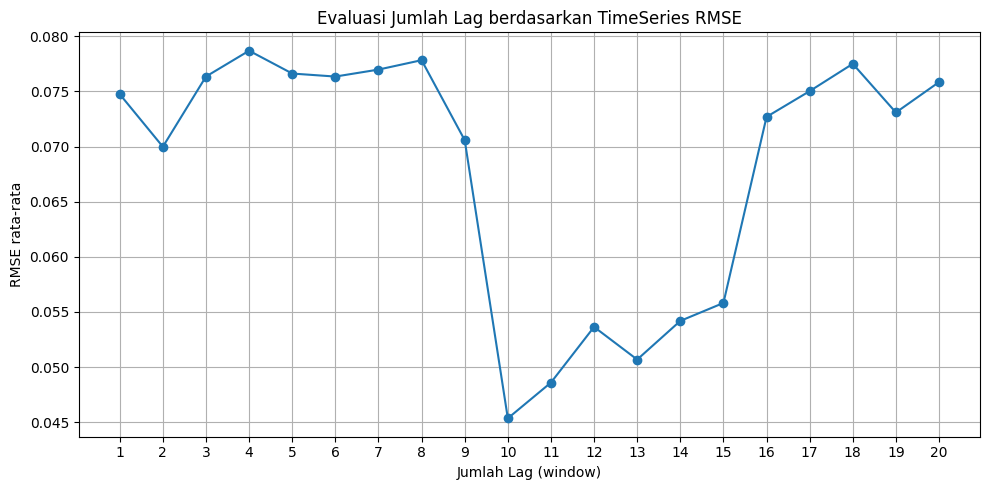

In [56]:
results_xgb = grid_search_best_lag(df_clean, target_columns, feature_columns, XGBRegressor(n_estimators=100, dart_normalized_type='forest'), )
plot_grid_results(results_xgb)
best_window_xgb = min(results_xgb, key=lambda x: x[1])[0]
xgb_rmse = min(results_xgb, key=lambda x: x[1])[1]

#### PREDIKSI DENGAN RANDOM FOREST

In [57]:
df_ml = create_multivariate_lag_features(df_clean, target_columns, feature_columns, best_window)
x = df_ml.drop(columns=target_columns)
y = df_ml[target_columns]

In [58]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [59]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(x_scaled, y_scaled)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

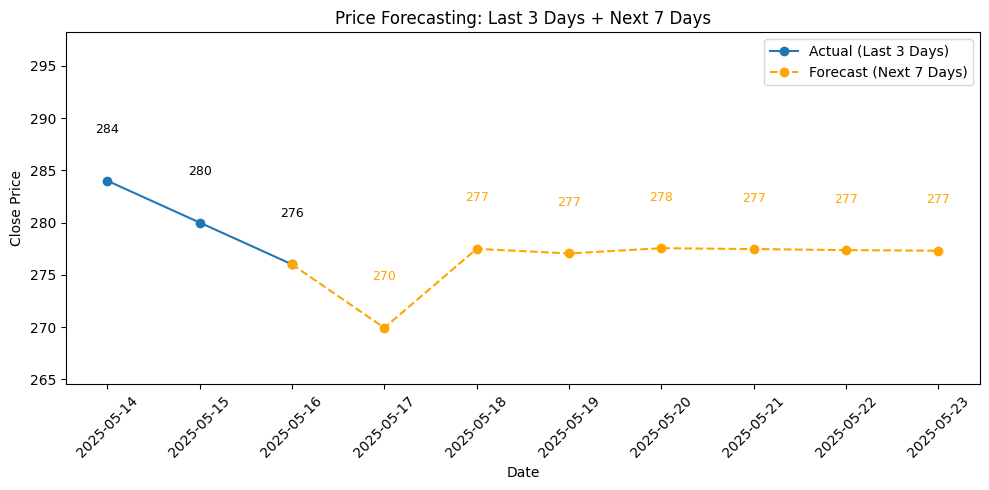

In [60]:
# Forecast
forecast = forecast_future(model, df_clean, scaler_x, scaler_y, target_columns, feature_columns, best_window, n_future=7)

# Visualisasi prediksi 'Close'
visualize_forecast(df_clean, forecast, tgt, n_future=7, last_n_days=3)

In [61]:
# Evaluasi di Data data training

from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Prediksi terhadap data training (rekonstruksi)
y_pred = model.predict(x_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_scaled)

# Evaluasi semua target
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_true_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_true_inv[:, i], y_pred_inv[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")

Open - MAPE: 0.36%, R²: 0.999


In [62]:
# Evaluasi di Data Test (7 Hari Terakhir)

df_test = df_clean[-(best_window + 7):]  # ambil untuk lag dan 7 hari
df_test_ml = create_multivariate_lag_features(df_test, target_columns, feature_columns, best_window)

x_test = df_test_ml.drop(columns=target_columns)
y_test = df_test_ml[target_columns]
x_test_scaled = scaler_x.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)

y_test_pred_scaled = model.predict(x_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_scaled)

print("\n[Hold-out Test Evaluation]")
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_test_true[:, i], y_test_pred[:, i])
    r2 = r2_score(y_test_true[:, i], y_test_pred[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")


[Hold-out Test Evaluation]
Open - MAPE: 0.32%, R²: 0.837


In [63]:
open_point_macl = pd.DataFrame({
    'Date': list(future_dates),
    'Open': list(forecast.reshape(1,-1)[0])
})
open_point_macl

,Date,Open
0,2025-05-17,269.92
1,2025-05-18,277.48
2,2025-05-19,277.04
3,2025-05-20,277.54
4,2025-05-21,277.46
5,2025-05-22,277.36
6,2025-05-23,277.30


#### PREDIKSI DENGAN XGBOOST

In [64]:
# Data untuk training
df_ml = create_multivariate_lag_features(df_clean, target_columns, feature_columns, best_window_xgb)
x = df_ml.drop(columns=target_columns)
y = df_ml[target_columns]

In [65]:
# Normalisasi
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [66]:
model_xgb = MultiOutputRegressor(XGBRegressor(n_estimators=100, dart_normalized_type='forest'))
model_xgb.fit(x_scaled, y_scaled)

c:\Programming\.vscode\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "dart_normalized_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            dart_normalized_type='forest',
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None, ...))

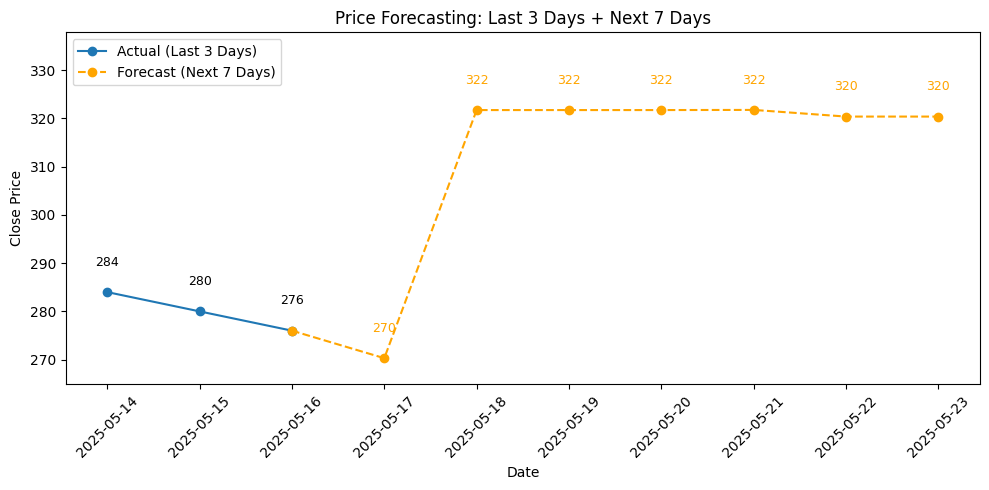

In [67]:
# Forecast
forecast_xgb = forecast_future(model_xgb, df_clean, scaler_x, scaler_y, target_columns, feature_columns, best_window_xgb, n_future=7)

# Visualisasi prediksi 'Close'
visualize_forecast(df_clean, forecast_xgb, tgt, n_future=7, last_n_days=3)

In [68]:
# Evaluasi di Data data training
# Prediksi terhadap data training (rekonstruksi)
y_pred = model_xgb.predict(x_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_scaled)

# Evaluasi semua target
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_true_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_true_inv[:, i], y_pred_inv[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")


Open - MAPE: 0.02%, R²: 1.000


In [69]:
# Evaluasi di Data Test (7 Hari Terakhir)

df_test = df_clean[-(best_window_xgb + 7):]  # ambil untuk lag dan 7 hari
df_test_ml = create_multivariate_lag_features(df_test, target_columns, feature_columns, best_window_xgb)

x_test = df_test_ml.drop(columns=target_columns)
y_test = df_test_ml[target_columns]
x_test_scaled = scaler_x.transform(x_test)
y_test_scaled = scaler_y.transform(y_test)

y_test_pred_scaled = model_xgb.predict(x_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_scaled)

print("\n[Hold-out Test Evaluation]")
for i, col in enumerate(target_columns):
    mape = mean_absolute_percentage_error(y_test_true[:, i], y_test_pred[:, i])
    r2 = r2_score(y_test_true[:, i], y_test_pred[:, i])
    print(f"{col} - MAPE: {mape:.2%}, R²: {r2:.3f}")



[Hold-out Test Evaluation]
Open - MAPE: 0.01%, R²: 1.000


In [70]:
open_point_xgb = pd.DataFrame({
    'Date': list(future_dates),
    'Open': list(forecast_xgb.reshape(1,-1)[0])
})
open_point_xgb

,Date,Open
0,2025-05-17,270.292674
1,2025-05-18,321.749737
2,2025-05-19,321.749737
3,2025-05-20,321.749737
4,2025-05-21,321.780443
5,2025-05-22,320.398985
6,2025-05-23,320.398985


---
### FORECASTING WITH SEASONAL DECOMPOSE

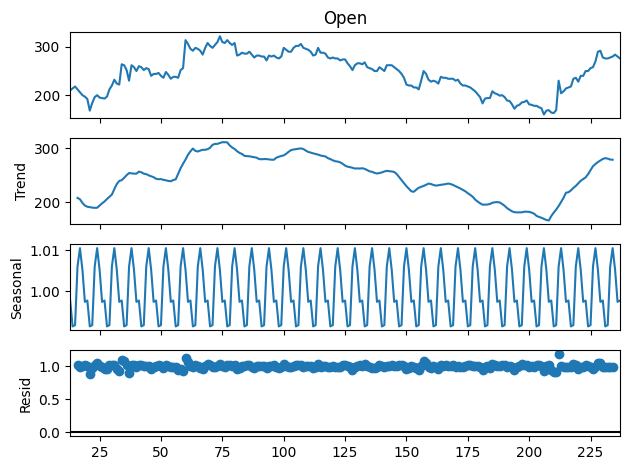

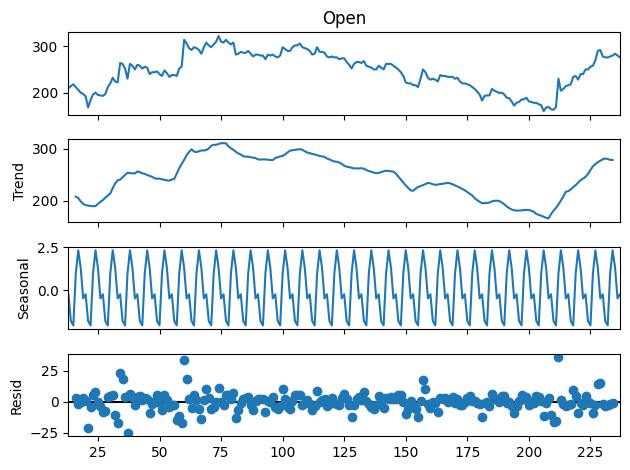

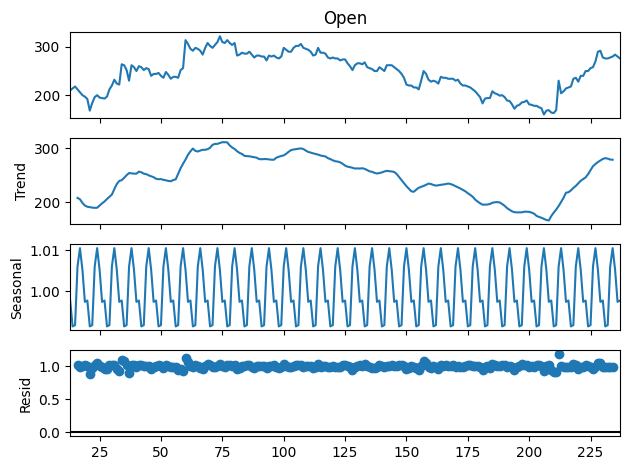

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df_clean[tgt], period=7, model='additive')
result_mul = seasonal_decompose(df_clean[tgt], period=7, model='multiplicative')
result_add.plot()
result_mul.plot()

In [119]:
mvg = df_clean[tgt].reset_index()
mvg['Moving Average'] = mvg[tgt].rolling(window=best_window).mean()
mvg[[tgt, 'Moving Average']].head(15)

,Open,Moving Average
0,210.0,NaN
1,214.0,NaN
2,218.0,NaN
3,212.0,NaN
4,206.0,NaN
5,200.0,NaN
6,197.0,NaN
7,192.0,NaN
8,168.0,NaN
9,184.0,200.1


In [120]:
stocks_data = list(df_clean[tgt].values)

n_future = 7
window = best_window
forecast_ma = []

for _ in range(n_future):
    if len(stocks_data) < window:
        avg = np.mean(stocks_data)
    else:
        print(stocks_data[-window:])
        avg = np.mean(stocks_data[-window:])
    forecast_ma.append(avg)
    stocks_data.append(avg)

[290.0, 292.0, 278.0, 276.0, 276.0, 278.0, 280.0, 284.0, 280.0, 276.0]
[292.0, 278.0, 276.0, 276.0, 278.0, 280.0, 284.0, 280.0, 276.0, 281.0]
[278.0, 276.0, 276.0, 278.0, 280.0, 284.0, 280.0, 276.0, 281.0, 280.1]
[276.0, 276.0, 278.0, 280.0, 284.0, 280.0, 276.0, 281.0, 280.1, 278.90999999999997]
[276.0, 278.0, 280.0, 284.0, 280.0, 276.0, 281.0, 280.1, 278.90999999999997, 279.001]
[278.0, 280.0, 284.0, 280.0, 276.0, 281.0, 280.1, 278.90999999999997, 279.001, 279.30109999999996]
[280.0, 284.0, 280.0, 276.0, 281.0, 280.1, 278.90999999999997, 279.001, 279.30109999999996, 279.63121000000007]


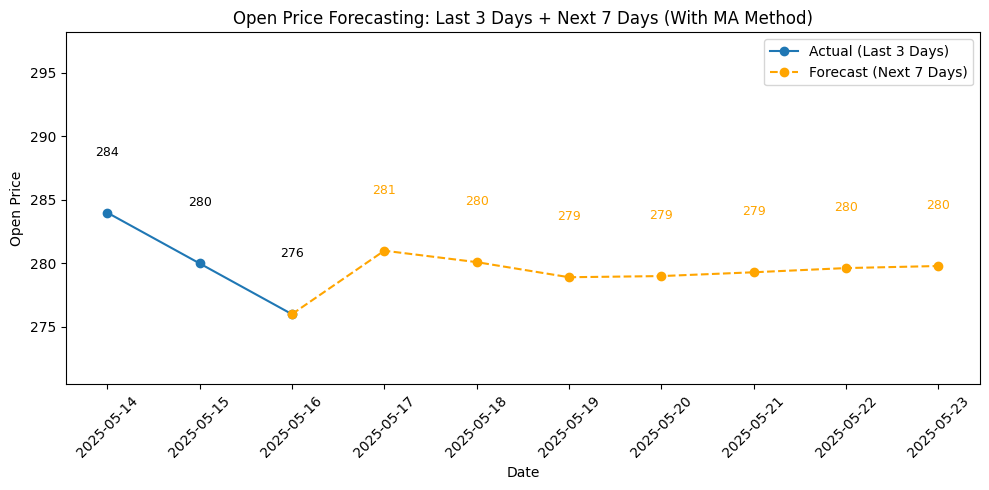

In [121]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + forecast_ma
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'Open Price Forecasting: Last 3 Days + Next 7 Days (With MA Method)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [122]:
open_point_ma = pd.DataFrame({
    'Date': list(future_dates),
    'Open': forecast_ma
})
open_point_ma

,Date,Open
0,2025-05-17,281.000000
1,2025-05-18,280.100000
2,2025-05-19,278.910000
3,2025-05-20,279.001000
4,2025-05-21,279.301100
5,2025-05-22,279.631210
6,2025-05-23,279.794331


### FORECASTING WITH EXPONENTIAL SMOOTHING

In [123]:
double = ExponentialSmoothing(df_clean[tgt].values, trend='mul', seasonal='mul', seasonal_periods=7).fit()

day = 7
double_forecast = double.forecast(steps=day)

print(f'prediksi harga berikutnya: {double_forecast}')

prediksi harga berikutnya: [275.27336093 275.03603538 277.76815173 279.50544965 278.85348176
 277.20663578 277.51011153]


c:\Programming\.vscode\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


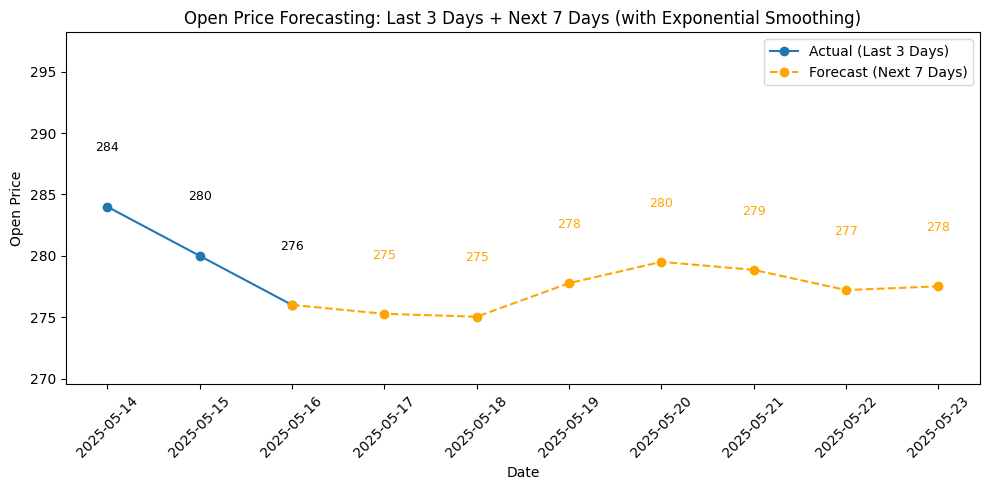

In [124]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + list(double_forecast)
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'Open Price Forecasting: Last 3 Days + Next 7 Days (with Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [125]:
open_point_es = pd.DataFrame({
    'Date': list(future_dates),
    'Open': list(double_forecast)
})
open_point_es

,Date,Open
0,2025-05-17,275.273361
1,2025-05-18,275.036035
2,2025-05-19,277.768152
3,2025-05-20,279.505450
4,2025-05-21,278.853482
5,2025-05-22,277.206636
6,2025-05-23,277.510112


### FORECASTING WITH SARIMAX

In [126]:
window = 3
df_ml_arima = create_lag_features(df_arima[tgt], window)
df_ml_arima

,lag_1,lag_2,lag_3,target
Date,,,,
2024-05-19,228.0,228.0,222.0,228.0
2024-05-20,228.0,228.0,228.0,230.0
2024-05-21,230.0,228.0,228.0,232.0
2024-05-22,232.0,230.0,228.0,226.0
2024-05-23,226.0,232.0,230.0,226.0
...,...,...,...,...
2025-05-12,280.0,280.0,280.0,280.0
2025-05-13,280.0,280.0,280.0,280.0
2025-05-14,280.0,280.0,280.0,284.0


c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

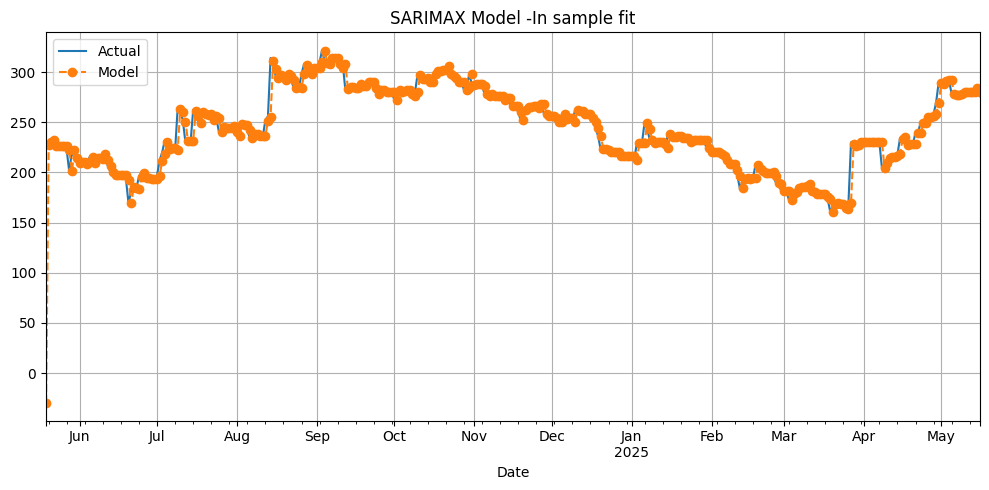

In [127]:
train = df_ml_arima
train['target'] = pd.to_numeric(train['target'], errors='coerce')
train[['lag_1', 'lag_2', 'lag_3']] = train[['lag_1', 'lag_2', 'lag_3']].apply(pd.to_numeric, errors='coerce')

train.index.freq = 'D'
auto = auto_arima(
    train['target'],
    exogenous=train[['lag_1', 'lag_2', 'lag_3']],
    seasonal=True,
    m=4,
    trace=False,
    suppress_warning=True,
    error_action='ignore',
    stepwise=True
)

p, d, q = auto.order
P, D, Q, s = auto.seasonal_order

model = SARIMAX(
    train['target'],
    exog=train[['lag_1', 'lag_2', 'lag_3']],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s)
)
model_fit = model.fit()

predictions = model_fit.predict(
    start=train.index[0],
    end=train.index[-1],
    exog=train[['lag_1', 'lag_2', 'lag_3']]
)

train['target'].plot(label='Actual', figsize=(10,5), legend=True)
predictions.plot(label='Model', linestyle='--', marker='o', legend=True)
plt.title('SARIMAX Model -In sample fit')
plt.grid(True)
plt.tight_layout()
plt.show()

In [128]:
last_values = list(df_ml_arima['target'].values[-3:])
n_future = 7
forecast_srmx= []

for _ in range(n_future):
    exog_future = pd.DataFrame([{
        'lag_1': last_values[-1],
        'lag_2': last_values[-2],
        'lag_3': last_values[-3]
    }])
    # print(exog_future)
    next_pred = model_fit.forecast(steps=1, exog=exog_future).iloc[0]
    forecast_srmx.append(next_pred)
    last_values.append(next_pred)

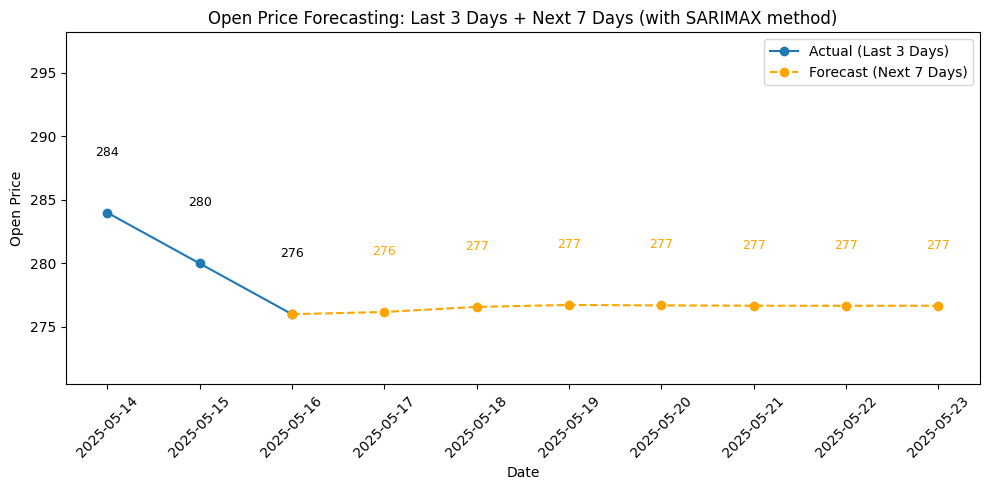

In [129]:
last_n_dates = df_clean['Date'].iloc[-3:].tolist()
last_n_close = df_clean[tgt].iloc[-3:].tolist()
last_date = df_clean['Date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D').tolist()

forecast_dates_full = [last_n_dates[-1]] + future_dates
forecast_values_full = [last_n_close[-1]] + list(forecast_srmx)
all_dates = last_n_dates + future_dates

plt.figure(figsize=(10, 5))
plt.plot(last_n_dates, last_n_close, label=f'Actual (Last 3 Days)', linestyle='-', marker='o')
plt.plot(forecast_dates_full, forecast_values_full, label='Forecast (Next 7 Days)', linestyle='--', marker='o', color='orange')

all_y_values = last_n_close + forecast_values_full[1:]
y_max = max(all_y_values)
y_min = min(all_y_values)
plt.ylim(y_min * 0.98, y_max * 1.05)


for date, value in zip(last_n_dates, last_n_close):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
for date, value in zip(forecast_dates_full[1:], forecast_values_full[1:]):
    plt.text(date, value + y_max * 0.015, f'{value:.0f}', ha='center', va='bottom', fontsize=9, color='orange')

plt.title(f'Open Price Forecasting: Last 3 Days + Next 7 Days (with SARIMAX method)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.xticks(ticks=all_dates, rotation=45)
plt.tight_layout()
plt.show()

In [130]:
open_point_srmx = pd.DataFrame({
    'Date': list(future_dates),
    'Open': list(forecast_srmx)
})
open_point_srmx

,Date,Open
0,2025-05-17,276.173386
1,2025-05-18,276.572167
2,2025-05-19,276.726273
3,2025-05-20,276.691232
4,2025-05-21,276.665958
5,2025-05-22,276.661938
6,2025-05-23,276.665043


## TREND PROJECTION OF VARIOUS METHODS

In [71]:
from functools import reduce
import plotly.graph_objects as go

In [72]:
main =  df.copy()
main['Date'] = pd.to_datetime(main['Date'], format="%b %d, %Y")
main = main.set_index('Date')
main = main.resample('D').ffill()
main.drop(columns=['Adj Close', 'Volume'], inplace=True)
main

,Open,High,Low,Close
Date,,,,
2024-05-16,222.0,232.0,222.0,228.0
2024-05-17,228.0,232.0,226.0,228.0
2024-05-18,228.0,232.0,226.0,228.0
2024-05-19,228.0,232.0,226.0,228.0
2024-05-20,230.0,240.0,228.0,232.0
...,...,...,...,...
2025-05-12,280.0,282.0,272.0,278.0
2025-05-13,280.0,282.0,272.0,278.0
2025-05-14,284.0,286.0,274.0,276.0


In [153]:
fig = go.Figure(data=[go.Candlestick(
    x=main.index[-180:],
    open=main['Open'].values[-180:],
    high=main['High'].values[-180:],
    low=main['Low'].values[-180:],
    close=main['Close'].values[-180:]
)])

fig.update_layout(xaxis_rangeslider_visible=False, 
                  title='Stock trend ADHI last 6 months',
                  xaxis_title=dict(text='Days'),
                  yaxis_title=dict(text='Price'))
fig.show()

### RANDOM FOREST PROJECTION

In [73]:
macl_df_list = [open_point_macl, high_point_macl, low_point_macl, close_point_macl]
machine_learning_method = reduce(lambda left, right: pd.merge(left, right, on='Date'), macl_df_list)
machine_learning_method = machine_learning_method.set_index('Date')
machine_learning_method = machine_learning_method.resample('D').ffill()

final_macl_df = pd.concat([main, machine_learning_method])
final_macl_df.to_csv('final_macl_df.csv', index=False)
final_macl_df.tail(8)

,Open,High,Low,Close
Date,,,,
2025-05-16,276.0,278.0,268.0,268.0
2025-05-17,269.92,281.72,259.36,272.32
2025-05-18,277.48,272.72,274.62,278.64
2025-05-19,277.04,272.02,275.08,276.52
2025-05-20,277.54,271.62,274.26,275.9
2025-05-21,277.46,271.96,274.02,275.56
2025-05-22,277.36,272.06,273.62,274.46
2025-05-23,277.3,272.52,272.78,273.7


In [74]:
scaler = 30

fig = go.Figure(data=[go.Candlestick(
    x=final_macl_df.index[-scaler:],
    open=final_macl_df['Open'].values[-scaler:],
    high=final_macl_df['High'].values[-scaler:],
    low=final_macl_df['Low'].values[-scaler:],
    close=final_macl_df['Close'].values[-scaler:]
)])

fig.update_layout(xaxis_rangeslider_visible=False, 
                  title='Stock trend ADHI with Random Forest',
                  xaxis_title=dict(text='Days'),
                  yaxis_title=dict(text='Price'))
fig.show()

REMARKS: Menurut hasil prediksi Random Forest, terlihat bahwa selama beberapa hari kedepan saham dibuka dengan keadaan bullish/uptrend, namun tidak bertahan lama kemudian saham akan mengalami kondisi bearish/downtrend. Hal ini terlihat dengan banyaknya nilai closing yang lebih rendah daripada opening. Nilai Opening pertama naik dari 270 poin ke 277 poin kemudian cenderung flat selama sepekan kedepan. Nilai High tertinggi berada pada 282 poin dengan nilai low terendah berada pada 259 poin. Sama halnya dengan nilai closing yang pertama naik dari 272 ke 278 poin namun berangsur-angsur turun hingga 274 poin. 

### XGBOOST PROJECTION

In [76]:
xgb_df_list = [open_point_xgb, high_point_xgb, low_point_xgb, close_point_xgb]
xgb_method = reduce(lambda left, right: pd.merge(left, right, on='Date'), xgb_df_list)
xgb_method = xgb_method.set_index('Date')
xgb_method = xgb_method.resample('D').ffill()

final_xgb_df = pd.concat([main, xgb_method])
final_xgb_df.to_csv('final_xgb_df.csv', index=False)
final_xgb_df.tail(8)

,Open,High,Low,Close
Date,,,,
2025-05-16,276.0,278.0,268.0,268.0
2025-05-17,270.292674,283.410235,259.932327,270.483588
2025-05-18,321.749737,311.011302,299.866371,292.338925
2025-05-19,321.749737,311.011302,305.467396,285.314151
2025-05-20,321.749737,311.011302,305.797844,289.31261
2025-05-21,321.780443,311.011302,300.538025,291.727906
2025-05-22,320.398985,311.011302,301.722879,291.491931
2025-05-23,320.398985,311.011302,291.302929,294.135724


In [77]:
fig = go.Figure(data=[go.Candlestick(
    x=final_xgb_df.index[-scaler:],
    open=final_xgb_df['Open'].values[-scaler:],
    high=final_xgb_df['High'].values[-scaler:],
    low=final_xgb_df['Low'].values[-scaler:],
    close=final_xgb_df['Close'].values[-scaler:]
)])

fig.update_layout(xaxis_rangeslider_visible=False, 
                  title='Stock trend ADHI with XGboost',
                  xaxis_title=dict(text='Days'),
                  yaxis_title=dict(text='Price'))
fig.show()

REMARKS: Menurut hasil prediksi XGBoost, beberapa hari kedepan posisi open berada di kisaran 321 poin namun sama seperti RandomForest, secara keseluruhan terlihat flat dengan trend menurun/bearish karena posisi Close point selalu lebih rendah dari Open Point. Bahkan menurut XGBoost posisi High tidak setinggi Open point dan posisi Low masih lebih tinggi daripada Closing point. Dengan kata lain posisi tertinggi per harinya merupakan Open point dan posisi terendah setiap harinya adalah Low Point. Nilai closing sekaligus low point terendah berada pada 285, dan nilai opening sekaligus high point tertinggi adalah 321 poin.  

### MOVING AVERAGE PROJECTION

In [146]:
ma_df_list = [open_point_ma, high_point_ma, low_point_ma, close_point_ma]
moving_average_method = reduce(lambda left, right: pd.merge(left, right, on='Date'), ma_df_list)
moving_average_method = moving_average_method.set_index('Date')
moving_average_method = moving_average_method.resample('D').ffill()

final_ma_df = pd.concat([main, moving_average_method])
final_ma_df.to_csv('final_ma_df.csv', index=False)
final_ma_df.tail(8)

,Open,High,Low,Close
Date,,,,
2025-05-16,276.0,278.0,268.0,268.0
2025-05-17,281.0,285.2,271.6,276.2
2025-05-18,280.1,284.32,270.76,274.62
2025-05-19,278.91,283.352,271.036,274.482
2025-05-20,279.001,283.4872,271.1396,274.3302
2025-05-21,279.3011,283.83592,271.25356,274.36322
2025-05-22,279.63121,283.819512,271.178916,274.599542
2025-05-23,279.794331,283.401463,271.096808,274.659496


In [138]:
final_ma_df = pd.read_csv('final_ma_df.csv')
final_ma_df

,Open,High,Low,Close
0,222.000000,232.000000,222.000000,228.000000
1,228.000000,232.000000,226.000000,228.000000
2,228.000000,232.000000,226.000000,228.000000
3,228.000000,232.000000,226.000000,228.000000
4,230.000000,240.000000,228.000000,232.000000
...,...,...,...,...
368,278.910000,283.352000,271.036000,274.482000
369,279.001000,283.487200,271.139600,274.330200
370,279.301100,283.835920,271.253560,274.363220
371,279.631210,283.819512,271.178916,274.599542


In [147]:
fig = go.Figure(data=[go.Candlestick(
    x=final_ma_df.index[-scaler:],
    open=final_ma_df['Open'].values[-scaler:],
    high=final_ma_df['High'].values[-scaler:],
    low=final_ma_df['Low'].values[-scaler:],
    close=final_ma_df['Close'].values[-scaler:]
)])

fig.update_layout(xaxis_rangeslider_visible=False, 
                  title='Stock trend ADHI with Moving Average',
                  xaxis_title=dict(text='Days'),
                  yaxis_title=dict(text='Price'))
fig.show()

REMARKS: Menurut hasil prediksi Moving Average, beberapa hari kedepan saham Adhi akan dibuka pada kisaran 279-281 poin namun terlihat perharinya bahwa harga closing selalu berada dibawah opening yang menandakan trend cenderung akan menurun/bearish. Nilai closing terendah berada pada poin 274 dan low point terendah berada pada poin 270, sementara itu high point tertinggi berada pada point 285.

### EXPONENTIAL SMOOTHING PROJECTION

In [148]:
es_df_list = [open_point_es, high_point_es, low_point_es, close_point_es]
es_method = reduce(lambda left, right: pd.merge(left, right, on='Date'), es_df_list)
es_method = es_method.set_index('Date')
es_method = es_method.resample('D').ffill()

final_es_df = pd.concat([main, es_method])
final_es_df.to_csv('final_es_df.csv', index=False)
final_es_df.tail(8)

,Open,High,Low,Close
Date,,,,
2025-05-16,276.0,278.0,268.0,268.0
2025-05-17,275.273361,278.109444,267.791613,267.43253
2025-05-18,275.036035,280.086084,267.843532,270.161072
2025-05-19,277.768152,284.738568,270.378069,272.736049
2025-05-20,279.50545,284.764454,269.393898,271.173197
2025-05-21,278.853482,280.729123,269.802997,269.038125
2025-05-22,277.206636,280.62741,269.199904,269.86892
2025-05-23,277.510112,278.503537,268.907662,268.426541


In [141]:
fig = go.Figure(data=[go.Candlestick(
    x=final_es_df.index[-scaler:],
    open=final_es_df['Open'].values[-scaler:],
    high=final_es_df['High'].values[-scaler:],
    low=final_es_df['Low'].values[-scaler:],
    close=final_es_df['Close'].values[-scaler:]
)])

fig.update_layout(xaxis_rangeslider_visible=False, 
                  title='Stock trend ADHI with Exponential Smoothing',
                  xaxis_title=dict(text='Days'),
                  yaxis_title=dict(text='Price'))
fig.show()

REMARKS: Menurut hasil prediksi Exponential Smoothing, beberapa hari kedepan saham Adhi akan dibuka pada kisaran 279-281 poin. Rentang Opening dan Closing cenderung terlihat bervariatif tiap harinya begitu juga rentang low dan closing. Namun secara keseluruhan terlihat perharinya bahwa harga closing selalu berada dibawah opening yang menandakan trend cenderung akan menurun/bearish. Nilai closing terendah berada pada 267 point dan low point terendah berada pada hari yang sama dengan 267 poin juga. Nilai high point tertinggi berada pada 285 point.

### SARIMAX PROJECTION

In [149]:
srmx_df_list = [open_point_srmx, high_point_srmx, low_point_srmx, close_point_srmx]
srmx_method = reduce(lambda left, right: pd.merge(left, right, on='Date'), srmx_df_list)
srmx_method = srmx_method.set_index('Date')
srmx_method = srmx_method.resample('D').ffill()

final_srmx_df = pd.concat([main, srmx_method])
final_srmx_df.to_csv('final_srmx_df.csv', index=False)
final_srmx_df.tail(8)

,Open,High,Low,Close
Date,,,,
2025-05-16,276.0,278.0,268.0,268.0
2025-05-17,276.173386,277.142516,267.895235,267.751829
2025-05-18,276.572167,277.666297,268.07892,268.467869
2025-05-19,276.726273,277.80185,268.166512,268.372847
2025-05-20,276.691232,277.810861,268.171605,268.301384
2025-05-21,276.665958,277.759754,268.16326,268.320282
2025-05-22,276.661938,277.786774,268.1594,268.325621
2025-05-23,276.665043,277.761847,268.159162,268.322837


In [143]:
fig = go.Figure(data=[go.Candlestick(
    x=final_srmx_df.index[-scaler:],
    open=final_srmx_df['Open'].values[-scaler:],
    high=final_srmx_df['High'].values[-scaler:],
    low=final_srmx_df['Low'].values[-scaler:],
    close=final_srmx_df['Close'].values[-scaler:]
)])

fig.update_layout(xaxis_rangeslider_visible=False, 
                  title='Stock trend ADHI with SARIMAX method',
                  xaxis_title=dict(text='Days'),
                  yaxis_title=dict(text='Price'))
fig.show()

REMARKS: Menurut hasil prediksi SARIMAX, beberapa hari kedepan nilai opening saham ADHI berada di kisaran 276 point, dan nilai closing ADHI berada pada kisaran 267 hingga 268 point. Terdapat rentang yang besar antara Opening dan Closing namun sama dengan permodelan yang lainnya harga Closing selalu lebih rendah dari opening yang menandakan majoritas sepekan kedepan saham ADHI akan diwarnai oleh donwtrend/bearish. Menurut permodelan SARIMAX saham akan mencapai titik tertingginya di 278 point.

## ANALISA FUNDAMENTAL SAHAM

### PENILAIAN P/E RATIO

P/E Ratio (Price-to-Earnings Ratio) adalah salah satu indikator yang paling umum digunakan untuk menilai valuasi sebuah saham. Rasio ini mengukur seberapa mahal harga sebuah saham dibandingkan dengan laba bersih perusahaan per sahamnya (EPS, Earnings per Share).

$
P/E Ratio= 
\frac{Harga Saham}{Laba per Saham (EPS)}\
​$

P/E tinggi → Investor bersedia membayar lebih mahal untuk setiap rupiah laba yang dihasilkan. Ini bisa berarti investor mengharapkan pertumbuhan laba yang tinggi di masa depan, atau bisa juga menandakan bahwa saham sedang overvalued.

P/E rendah → Saham dianggap murah relatif terhadap labanya. Ini bisa menjadi sinyal bahwa saham undervalued, atau sebaliknya menandakan risiko (misal, pertumbuhan melambat, masalah bisnis, dll).

In [92]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
import time
import re

container_pe = []
chrome_options = Options()
chrome_options.add_argument("--ignore-certificate-errors")  # Avoid SSL errors
chrome_options.add_argument("--allow-running-insecure-content")

service = Service(r'C:\Programming\.vscode\BootcampBatch9\chromedriver-win64\chromedriver.exe')
driver = webdriver.Chrome(service=service, options=chrome_options)
driver.get("https://finbox.com/IDX:ADHI/explorer/pe_ltm/")
time.sleep(10)
actions = ActionChains(driver)

target = driver.find_element(By.CLASS_NAME, 'bd30e728')
actions.click(target).perform()
time.sleep(3)
target2 = driver.find_element(By.XPATH, '//*[@id="root"]/div/div[4]/div[3]/div[2]/div[1]/div[1]/div[2]/div[1]/div/div[2]/div[2]')
actions.click(target2).perform()
time.sleep(3)

slider = driver.find_element(By.CLASS_NAME, 'recharts-cartesian-grid')
actions.click(slider).move_by_offset(205, 0).perform()
counter = 205
while counter > -95:
    lookout = driver.find_element(By.CLASS_NAME, 'abc7a257').text
    container_pe.append(lookout)
    time.sleep(2)
    actions.move_by_offset(-10, 0).perform()
    time.sleep(2)
    counter -= 10

driver.close()

counter is: 205
P/E Ratio
March 31, 2025: 9.3x
counter is: 195
P/E Ratio
December 31, 2024: 6.9x
counter is: 185
P/E Ratio
September 30, 2024: 10.5x
counter is: 175
P/E Ratio
June 30, 2024: 7.7x
counter is: 165
P/E Ratio
March 31, 2024: 11.5x
counter is: 155
P/E Ratio
December 31, 2023: 31.3x
counter is: 145
P/E Ratio
September 30, 2023: 48.0x
counter is: 135
P/E Ratio
June 30, 2023: 45.8x
counter is: 125
P/E Ratio
March 31, 2023: 43.1x
counter is: 115
P/E Ratio
December 31, 2022: 68.7x
counter is: 105
P/E Ratio
September 30, 2022: 44.6x
counter is: 95
P/E Ratio
June 30, 2022: 49.4x
counter is: 85
P/E Ratio
March 31, 2022: 47.7x
counter is: 75
P/E Ratio
March 31, 2022: 47.7x
counter is: 65
P/E Ratio
December 31, 2021: 124.4x
counter is: 55
P/E Ratio
September 30, 2021: 135.5x
counter is: 45
P/E Ratio
June 30, 2021: 124.6x
counter is: 35
P/E Ratio
March 31, 2021: 162.6x
counter is: 25
P/E Ratio
December 31, 2020: 16.7x
counter is: 15
P/E Ratio
September 30, 2020: 3.9x
counter is: 5
P/E 

In [97]:
dates_pe = []
values_pe = []

for entry in container_pe:
    match = re.search(r'(\w+ \d{1,2}, \d{4}): ([\d.]+)x', entry)
    if match:
        dates_pe.append(match.group(1))
        values_pe.append(float(match.group(2)))

['March 31, 2025', 'December 31, 2024', 'September 30, 2024', 'June 30, 2024', 'March 31, 2024', 'December 31, 2023', 'September 30, 2023', 'June 30, 2023', 'March 31, 2023', 'December 31, 2022', 'September 30, 2022', 'June 30, 2022', 'March 31, 2022', 'March 31, 2022', 'December 31, 2021', 'September 30, 2021', 'June 30, 2021', 'March 31, 2021', 'December 31, 2020', 'September 30, 2020', 'June 30, 2020', 'March 31, 2020', 'December 31, 2019', 'September 30, 2019', 'June 30, 2019', 'March 31, 2019', 'December 31, 2018', 'September 30, 2018', 'June 30, 2018', 'March 31, 2018']
[9.3, 6.9, 10.5, 7.7, 11.5, 31.3, 48.0, 45.8, 43.1, 68.7, 44.6, 49.4, 47.7, 47.7, 124.4, 135.5, 124.6, 162.6, 16.7, 3.9, 3.6, 2.9, 6.3, 7.4, 9.3, 9.1, 8.7, 8.3, 11.2, 14.3]


In [98]:
pe_ratio = pd.DataFrame({
    'Date': dates_pe,
    'Value': values_pe
})
pe_ratio.to_csv('pe_ratio.csv', index=False)
pe_ratio

,Date,Value
0,"March 31, 2025",9.3
1,"December 31, 2024",6.9
2,"September 30, 2024",10.5
3,"June 30, 2024",7.7
4,"March 31, 2024",11.5
5,"December 31, 2023",31.3
6,"September 30, 2023",48.0
7,"June 30, 2023",45.8
8,"March 31, 2023",43.1
9,"December 31, 2022",68.7


In [84]:
# pe_ratio = pd.read_csv('pe_ratio.csv')

pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'], format="%B %d, %Y")
pe_ratio

,Date,Value
0,2025-03-31,9.3
1,2024-12-31,6.9
2,2024-09-30,10.5
3,2024-06-30,7.7
4,2024-03-31,11.5
5,2023-12-31,31.3
6,2023-09-30,48.0
7,2023-06-30,45.8
8,2023-03-31,43.1
9,2022-12-31,68.7


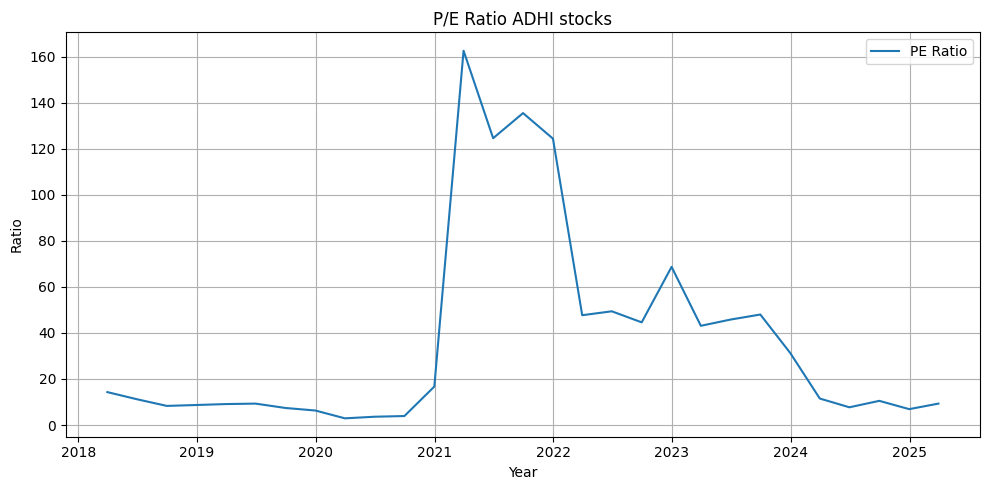

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(pe_ratio['Date'].values, pe_ratio['Value'].values, label='PE Ratio')
plt.title('P/E Ratio ADHI stocks')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

REMARKS: Disini terlihat saham ADHI memiliki nilai P/E ratio sebesar ~10, menunjukkan bahwa saham ini dihargai lebih rendah dibandingkan rata-rata industri, yang bisa menjadi indikasi bahwa saham ini undervalued (Jika dibandingkan dengan rata-rata industri konstruksi di Indonesia yang memiliki P/E sekitar 17,1).

### PENILAIAN P/BV RATIO

P/BV Ratio (Price-to-Book Value Ratio) adalah rasio keuangan yang membandingkan harga pasar saham dengan nilai buku (book value) perusahaan. Ini membantu investor menilai apakah saham dihargai wajar, mahal, atau murah dibandingkan dengan aset bersih perusahaan.

$
P/BV Ratio= 
\frac{Harga Saham}{Nilai Buku per Saham (Book Value per Share)}\
​$

P/BV < 1
Saham diperdagangkan di bawah nilai buku → bisa menjadi sinyal undervalued. Bisa menarik jika perusahaan sehat.

P/BV = 1
Saham dihargai setara dengan nilai aset bersihnya.

P/BV > 1
Saham dihargai lebih mahal dari nilai buku → pasar percaya perusahaan punya prospek bagus atau aset tidak terlihat (misal: merek, goodwill, inovasi).

In [99]:
chrome_options = Options()
chrome_options.add_argument("--ignore-certificate-errors")  # Avoid SSL errors
chrome_options.add_argument("--allow-running-insecure-content")

container_pbv = []
service = Service(r'C:\Programming\.vscode\BootcampBatch9\chromedriver-win64\chromedriver.exe')
driver = webdriver.Chrome(service=service, options=chrome_options)
driver.get("https://finbox.com/IDX:ADHI/explorer/price_to_book")
time.sleep(10)
actions = ActionChains(driver)

target = driver.find_element(By.CLASS_NAME, 'bd30e728')
actions.click(target).perform()
time.sleep(3)
target2 = driver.find_element(By.XPATH, '//*[@id="root"]/div/div[4]/div[3]/div[2]/div[1]/div[1]/div[2]/div[1]/div/div[2]/div[2]')
actions.click(target2).perform()
time.sleep(3)

slider = driver.find_element(By.CLASS_NAME, 'recharts-cartesian-grid')
actions.click(slider).move_by_offset(205, 0).perform()
counter = 205
while counter > -95:
    lookout = driver.find_element(By.CLASS_NAME, 'abc7a257').text
    container_pbv.append(lookout)
    time.sleep(2)
    actions.move_by_offset(-10, 0).perform()
    time.sleep(2)
    counter -= 10

driver.close()

counter is: 205
Price / Book
March 31, 2025: 0.2x
counter is: 195
Price / Book
December 31, 2024: 0.2x
counter is: 185
Price / Book
September 30, 2024: 0.3x
counter is: 175
Price / Book
June 30, 2024: 0.2x
counter is: 165
Price / Book
March 31, 2024: 0.3x
counter is: 155
Price / Book
December 31, 2023: 0.3x
counter is: 145
Price / Book
September 30, 2023: 0.5x
counter is: 135
Price / Book
June 30, 2023: 0.5x
counter is: 125
Price / Book
March 31, 2023: 0.4x
counter is: 115
Price / Book
December 31, 2022: 0.7x
counter is: 105
Price / Book
September 30, 2022: 0.4x
counter is: 95
Price / Book
June 30, 2022: 0.5x
counter is: 85
Price / Book
March 31, 2022: 0.5x
counter is: 75
Price / Book
March 31, 2022: 0.5x
counter is: 65
Price / Book
December 31, 2021: 0.6x
counter is: 55
Price / Book
September 30, 2021: 0.6x
counter is: 45
Price / Book
June 30, 2021: 0.5x
counter is: 35
Price / Book
March 31, 2021: 0.7x
counter is: 25
Price / Book
December 31, 2020: 1.0x
counter is: 15
Price / Book
Sep

In [102]:
dates_pbv = []
values_pbv = []

for entry in container_pbv:
    match = re.search(r'(\w+ \d{1,2}, \d{4}): ([\d.]+)x', entry)
    if match:
        dates_pbv.append(match.group(1))
        values_pbv.append(float(match.group(2)))

['March 31, 2025', 'December 31, 2024', 'September 30, 2024', 'June 30, 2024', 'March 31, 2024', 'December 31, 2023', 'September 30, 2023', 'June 30, 2023', 'March 31, 2023', 'December 31, 2022', 'September 30, 2022', 'June 30, 2022', 'March 31, 2022', 'March 31, 2022', 'December 31, 2021', 'September 30, 2021', 'June 30, 2021', 'March 31, 2021', 'December 31, 2020', 'September 30, 2020', 'June 30, 2020', 'March 31, 2020', 'December 31, 2019', 'September 30, 2019', 'June 30, 2019', 'March 31, 2019', 'December 31, 2018', 'September 30, 2018', 'June 30, 2018', 'March 31, 2018']
[0.2, 0.2, 0.3, 0.2, 0.3, 0.3, 0.5, 0.5, 0.4, 0.7, 0.4, 0.5, 0.5, 0.5, 0.6, 0.6, 0.5, 0.7, 1.0, 0.3, 0.4, 0.3, 0.6, 0.7, 0.9, 0.9, 0.9, 0.8, 1.1, 1.3]


In [103]:
pbv_ratio = pd.DataFrame({
    'Date': dates_pbv,
    'Value': values_pbv
})
pbv_ratio.to_csv('pbv_ratio.csv', index=False)
pbv_ratio

,Date,Value
0,"March 31, 2025",0.2
1,"December 31, 2024",0.2
2,"September 30, 2024",0.3
3,"June 30, 2024",0.2
4,"March 31, 2024",0.3
5,"December 31, 2023",0.3
6,"September 30, 2023",0.5
7,"June 30, 2023",0.5
8,"March 31, 2023",0.4
9,"December 31, 2022",0.7


In [86]:
# pbv_ratio = pd.read_csv('pbv_ratio.csv')

pbv_ratio['Date'] = pd.to_datetime(pbv_ratio['Date'], format="%B %d, %Y")
pbv_ratio

,Date,Value
0,2025-03-31,0.2
1,2024-12-31,0.2
2,2024-09-30,0.3
3,2024-06-30,0.2
4,2024-03-31,0.3
5,2023-12-31,0.3
6,2023-09-30,0.5
7,2023-06-30,0.5
8,2023-03-31,0.4
9,2022-12-31,0.7


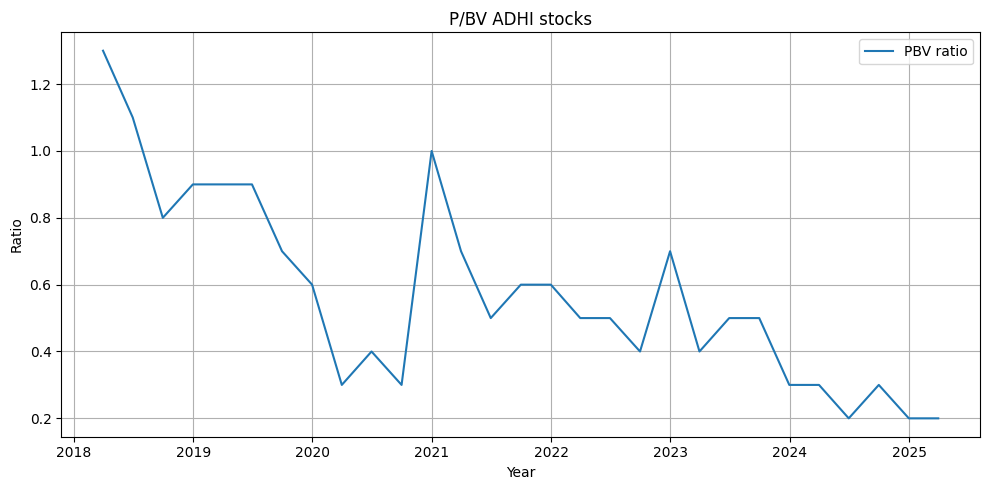

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(pbv_ratio['Date'].values, pbv_ratio['Value'].values, label='PBV ratio')
plt.title('P/BV ADHI stocks')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

REMARKS: Price-to-Book Value (P/BV) ratio saham PT Adhi Karya (Persero) Tbk (ADHI) berada di 0.2. P/BV di bawah 1 menandakan bahwa harga saham diperdagangkan di bawah nilai buku perusahaan. Dalam kasus ADHI, nilai ini menunjukkan bahwa investor hanya membayar sekitar 20% dari nilai aset bersih perusahaan per saham.

### PENILAIAN BALANCE SHEET PERUSAHAAN

Pada section ini kita akan melihat cuplikan balance sheet dari perusahaan ADHI dan kita akan melihat Aset/Liabilities Ratio untuk mengecek apakah perusahaan mampu memenuhi semua obligasinya dalam jangka panjang, serta Debt/Equities Ratio untuk menilai seberapa banyak hutang yang dimiliki perusahaan terhadap modal sendiri. Data ini diambil berdasarkan kinerja bisnis selama 12 bulan terakhir, dan ditampilkan dalam DataFrame dalam satuan Milyar.

In [ ]:
chrome_options = Options()
chrome_options.add_argument("--ignore-certificate-errors")  # Avoid SSL errors
chrome_options.add_argument("--allow-running-insecure-content")

service = Service(r'C:\Programming\.vscode\BootcampBatch9\chromedriver-win64\chromedriver.exe')
driver = webdriver.Chrome(service=service, options=chrome_options)
driver.get("https://finance.yahoo.com/quote/ADHI.JK/balance-sheet/")
time.sleep(5)

actions = ActionChains(driver)
target = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.ID, 'tab-quarterly'))
)
target = driver.find_element(By.ID, 'tab-quarterly')
actions.click(target).perform()
time.sleep(5)

rowTitle = driver.find_elements(By.CLASS_NAME, "rowTitle")
tableName = []
for i in range(1, len(rowTitle) + 1):
    tableTitle = driver.find_element(By.XPATH, f'//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div/div[2]/div[{i}]/div[1]/div')
    tableName.append(tableTitle.text)
    time.sleep(2)

retrievedVal = []
for i in range(1, len(rowTitle) + 1):
    levels = driver.find_element(By.XPATH, f'//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div/div[2]/div[{i}]/div[2]')
    retrievedVal.append(levels.text)
    time.sleep(2)

driver.close()

Total Assets
Total Liabilities Net Minority Interest
Total Equity Gross Minority Interest
Total Capitalization
Common Stock Equity
Capital Lease Obligations
Net Tangible Assets
Working Capital
Invested Capital
Tangible Book Value
Total Debt
Net Debt
Share Issued
Ordinary Shares Number
34,498,309,690.10
24,816,397,706.08
9,681,911,984.01
13,480,789,680.41
9,041,750,337.64
20,042,952.24
9,041,750,337.64
2,537,237,151.78
17,688,808,505.23
9,041,750,337.64
8,667,101,119.82
7,017,815,367.42
8,407,608.98
8,407,608.98


In [79]:
cleaned_floats = [(float(re.sub(r",", "", number))/1e9) for number in retrievedVal]
balance_sheet = pd.DataFrame({
    'Breakdown': tableName,
    'Value': cleaned_floats
})
balance_sheet.to_csv('balance_sheet.csv', index=False)
balance_sheet

,Breakdown,Value
0,Total Assets,34.498310
1,Total Liabilities Net Minority Interest,24.816398
2,Total Equity Gross Minority Interest,9.681912
3,Total Capitalization,13.480790
4,Common Stock Equity,9.041750
5,Capital Lease Obligations,0.020043
6,Net Tangible Assets,9.041750
7,Working Capital,2.537237
8,Invested Capital,17.688809
9,Tangible Book Value,9.041750


In [101]:
# balance_sheet = pd.read_csv('balance_sheet.csv')

# Total Assets / Total Liabilities 
ta_tl = balance_sheet.loc[balance_sheet.Breakdown == 'Total Assets', 'Value'].values / balance_sheet.loc[balance_sheet.Breakdown == 'Total Liabilities Net Minority Interest', 'Value'].values
print(f'Total Asset / Total Liabilitas: {ta_tl[0]:.2f}')

# Debt-to-Equity Ratio
de_eq = balance_sheet.loc[balance_sheet.Breakdown == 'Total Debt', 'Value'].values / balance_sheet.loc[balance_sheet.Breakdown == 'Total Equity Gross Minority Interest', 'Value'].values
print(f'Total Hutang / Total Ekuitas: {de_eq[0]:.2f}')

Total Asset / Total Liabilitas: 1.39
Total Hutang / Total Ekuitas: 0.90


REMARKS:
Rasio Total Aset / Total Liabilitas 1,39 menunjukkan bahwa ADHI memiliki posisi keuangan yang relatif sehat dan likuiditas yang aman. Artinya, perusahaan cukup mampu menutup semua utangnya dengan aset yang dimiliki.

Rasio Total Hutang / Ekuitas = 0,9 menunjukkan bahwa utang ADHI lebih kecil dibandingkan modal pemilik. Artinya struktur pendanaan perusahaan tidak terlalu bergantung pada utang, sehingga risiko finansial tergolong moderat dan terkendali.

### PENILAIAN CASH FLOW PERUSAHAAN

Pada section ini kita akan melihat cuplikan Arus Kas dari perusahaan ADHI dan kita akan melihat bagaimana arus kas operasional (perputaran uang karena operasional perusahaan), arus kas investasi(uang yang dibutuhkan untuk investasi aset dsbg), arus kas kebutuhan finansial (uang yang digunakan untuk pembayaran dividen, atau pembayaran hutang), serta arus kas bebas(jumlah uang dipotong biaya pengembangan seperti CAPEX). Data ini diambil berdasarkan kinerja bisnis selama 12 bulan terakhir, dan ditampilkan dalam DataFrame dalam satuan Milyar.

In [80]:
chrome_options = Options()
chrome_options.add_argument("--ignore-certificate-errors")  # Avoid SSL errors
chrome_options.add_argument("--allow-running-insecure-content")

service = Service(r'C:\Programming\.vscode\BootcampBatch9\chromedriver-win64\chromedriver.exe')
driver = webdriver.Chrome(service=service, options=chrome_options)
driver.get("https://finance.yahoo.com/quote/ADHI.JK/cash-flow/")
time.sleep(10)

actions = ActionChains(driver)
target = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.ID, 'tab-quarterly'))
)
target = driver.find_element(By.ID, 'tab-quarterly')
actions.click(target).perform()
time.sleep(5)

rowTitle = driver.find_elements(By.CLASS_NAME, "rowTitle")
tableName = []
for i in range(1, len(rowTitle) + 1):
    tableTitle = driver.find_element(By.XPATH, f'//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div/div[2]/div[{i}]/div[1]/div')
    tableName.append(tableTitle.text)
    time.sleep(2)

retrievedVal = []
for i in range(1, len(rowTitle) + 1):
    levels = driver.find_element(By.XPATH, f'//*[@id="nimbus-app"]/section/section/section/article/article/section/div/div/div[2]/div[{i}]/div[2]')
    retrievedVal.append(levels.text)
    time.sleep(2)

driver.close()

In [88]:
cleaned_floats = []
for item in retrievedVal:
    if re.fullmatch(r"-{2,}", item.strip()):
        cleaned_floats.append(None) 
    else:
        cleaned = re.sub(r",", "", item)
        cleaned_floats.append(float(cleaned) / 1e9)

print(cleaned_floats)

[-0.54402364215, -0.10577945433, -4.14356518289, 1.6292428001700001, -0.04230997539, None, 3.17127031902, -6.52957186335, -0.5863336175399999]


In [89]:
cash_flow = pd.DataFrame({
    'Breakdown': tableName,
    'Value': cleaned_floats
})
cash_flow.to_csv('cash_flow.csv', index=False)
cash_flow

# cash_flow = pd.read_csv('cash_flow.csv')

,Breakdown,Value
0,Cash Flows from Used in Operating Activities D...,-0.544024
1,Investing Cash Flow,-0.105779
2,Financing Cash Flow,-4.143565
3,End Cash Position,1.629243
4,Capital Expenditure,-0.042310
5,Issuance of Capital Stock,NaN
6,Issuance of Debt,3.171270
7,Repayment of Debt,-6.529572
8,Free Cash Flow,-0.586334


REMARKS:
1. Perusahaan mencatat arus kas dari aktivitas operasional (Operating Cash Flow) sebesar -0,544 milyar, yang berarti ADHI mengalami arus kas keluar dari kegiatan utama operasionalnya. Hal ini menunjukkan bahwa selama periode tersebut, kegiatan usaha inti belum menghasilkan kas positif.
2. Free Cash Flow (FCF) juga berada di angka negatif -0,586 milyar, yang mencerminkan bahwa setelah dikurangi belanja modal (capital expenditure), perusahaan masih mengalami defisit kas. Ini memperkuat sinyal bahwa ADHI belum menghasilkan kas bebas yang cukup untuk ekspansi atau membayar dividen tanpa mencari pembiayaan tambahan.
3. Dari sisi Investing Cash Flow, tercatat negatif -0,106 milyar, yang mengindikasikan adanya pengeluaran untuk investasi atau pembelian aset tetap. Meskipun nilainya tidak besar, ini menunjukkan aktivitas ekspansi atau perawatan aset tetap tetap berjalan.
4. Financing Cash Flow tercatat sangat negatif di angka -4,144 milyar, menunjukkan bahwa perusahaan lebih banyak melakukan pelunasan utang (sebesar -6,53 milyar) dibanding penerbitan utang baru (3,17 milyar). Hal ini menunjukkan strategi perusahaan untuk mengurangi beban utang, meskipun harus mengorbankan kas dalam jumlah besar.

Secara keseluruhan, ADHI menunjukkan arus kas yang negatif dari sisi operasional dan bebas (FCF), yang mengindikasikan tantangan dalam menghasilkan kas dari kegiatan inti. Meskipun ada aktivitas investasi yang moderat, beban pengeluaran paling besar berasal dari pembayaran utang. Strategi keuangan saat ini tampaknya berfokus pada penyehatan struktur utang, namun dengan konsekuensi menurunnya posisi kas bersih selama periode berjalan.


## KESIMPULAN

Dengan menggunakan 4 metode yakni Machine Learning (menggunakan `RandomForestRegressor` dan `XGBoostRegressor`), Moving Average, Exponential Smoothing dan SARIMAX, kita dapat melakukan analisa teknikal pada sebuah saham. Setiap metode memang memiliki hasil nilai Open, Close, High dan Low yang berbeda-beda namun secara keseluruhan mereka menampilkan pola yang selalu sama yakni nilai Closing lebih rendah daripada nilai Opening per harinya. Sehingga berdasarkan analisa teknikal dari keempat metode datas, kita bisa melihat bahwa performa saham ADHI akan mengalami downtrend/bearish dalam sepekan kedepan. 

Secara fundamental saham ADHI memang tergolong murah (berdasarkan nilai P/E dan P/BV ratio) dan juga memiliki neraca keuangan(Balance Sheet) yang kuat sehingga menarik untuk dibeli. Namun, jika kita melihat arus kas perusahaan kita dapat melihat bahwa mayoritas berada pada posisi negatif. Hal ini bisa berarti 3 hal: Perusahaan sedang berinvestasi besar-besaran untuk pengembangan, atau hanyalah kondisi buruk yang seasonal, atau memang bisnis perusahaan sedang memburuk. Manapun alasan penyebab hal ini terjadi tetap menandakan saham ADHI memiliki resiko yang besar untuk investasi kedepannya.

Sehingga berdasarkan hasil analisa teknikal dan analisa fundamental diatas, penulis menyarankan untuk tidak membeli saham ADHI baik untuk kepentingan trading maupun investasi dalam kuartal ini hingga kuartal selanjutnya. Riset lebih lanjut akan dibutuhkan pada kuartal selanjutnya untuk mengecek apakah ada perubahan pada nilai teknikal maupun fundamental.